# ADAMS SS2020 Assignment — Gleb Zhidkov

This notebook examines a dataset consisting of articles scraped from [Medium.com](http://medium.com/), an online publishing platform for social journalism, with articles and blogs published by both amateuers and professionals from various indistries, including (but going far beyond) Data Science and Machine Learning practitioners.

Data is briefly introduced, after which it is extensively cleaned and prepared for the later modeling, which aims at predicting the number of claps (likes) an article received as of scraping date.

Last updated on 31. August 2020

---

**Sneak peak at the final model:**

![ensemble1](https://drive.google.com/uc?export=view&id=1iLTXpDx8AOXDywTcfGJ0jP_IY4gamZQL)

_(Should diagrams fail to load, please access them in a [Google Drive folder](https://drive.google.com/drive/folders/1nrFeXpshV6pGgZVjlKGdELrzV44iIpn3). Credit is given to a Stack Overflow user for [providing a method](https://stackoverflow.com/a/62337161/12451060) to insert images available both in Jupyter and in Colab.)_

---

## Technical introduction

Given a noticeably big size of the examined dataset as well as high computational and memory requirements at both the data preparation and modeling steps, it appears important to pay a bigger attention to a) efficiency of the code b) adequacy of the working environment for the current task. 

Whereas [Google Colaboratory](https://colab.research.google.com/) (Colab) provides free access to GPU/TPU, it imposes relatively strict restrictions on RAM usage. 

For data preparation and text tokenization, there was no significant difference in computational time between my local environment (MacBook Air with only 8 GB RAM) and Colab. 
Nonetheless, parts of the code had to be re-written several times to limit memory usage. In particular, storing vector representations of tokenized documents turned out to be a bigger challenge than anticipated. An array storing 66141 articles in the (cleaned) train dataset, limited to 100 words each represented on 300 dimensions consumes 4 GB when numbers are stored in the half-precision floating-point format _(float16)_. Using _float32_ would require 8 GB and _float64_ 16 GB of memory, causing severe difficulties when training the model (as this array would have been to be stored in RAM while training).

Colab has proven itself to be of no good use for training CNNs as it was quickly running out of RAM (12 GB available) and crashing. At the same time, the Macbook with less available RAM was able to make use of the swap memory, therefore never running into out-of-memory errors. Applying transformer models, on contrary, is not realistic without a GPU, and Colab had to be used for this part of the notebook.

In the following cells, the working environment is set up, and several custom helper classes and functions are loaded from .py-files. Some further helper functions are defined in this notebook to enhance ease of readability. All custom classes and functions come with documentation strings where appropriate; references are provided for code re-used from other sources.

In [1]:
## colab or local?
## NOTE: adjust directories DIR and DATA_DIR to your local if required

import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = '/content/drive/My Drive/uni master 2/ADAMS/work/'
    DATA_DIR = DIR + 'data/'
    sys.path.append(os.path.abspath(DIR)) # to access custom modules
    print('Running in Colab. Downloading spacy dictionary') # WHERE IS CODE FOR DICT?
else:
    DIR = ''
    DATA_DIR = DIR + 'data/'
    print('Running locally.')

Running locally.


In [2]:
from textstat import flesch_kincaid_grade
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle
import spacy

pd.set_option('display.float_format', lambda x: '%.0f' % x)

from helper import ReplaceOutliers, clean_text, boxplot, sort_dict, nonnegative
from tokenizer2 import Tokenizer2, words_to_docs
from models2 import Models

# install statistical language model for spacy
# !{sys.executable} -m spacy download en_core_web_lg

---
# DATA PREPARATION

## First look onto data

The two provided datasets (`Train.csv` which will later be split into the actual train and test data, and `Test.csv` which is used solely for the final assignment predictions) greatly differ in their structure. 
They come with different challenges: the train dataset has a tidy structure but a great number of duplicates and a choice of non-English articles; the test dataset has mixed up feature values and requires some careful handling of string features.

All important considerations and insights about the data structure are presented in the following. Parts of the code required to verify these insights are commented out. The original (and a rather messy) code for the first examination of data structure is not presented in this notebook due to its low relevancy for the assignment task.

In [ ]:
train_raw = pd.read_csv(DATA_DIR + 'Train.csv')
test_raw = pd.read_csv(DATA_DIR + 'Test.csv')

test_raw.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)

In [ ]:
print(f'Train dataset: {train_raw.shape[0]} rows and {train_raw.shape[1]} columns; \n'
      f'Test dataset:  {test_raw.shape[0]} rows and {test_raw.shape[1]} columns. \n\n'
      
      f"In the train dataset, articles are written in {len(train_raw['language'].unique())} languages, "
      f"with {round(100*sum(train_raw['language'] != 'en') / train_raw.shape[0], 2)} "
      "% of articles not in English.\n"
)

print(f"Articles were repeatedly scraped for up to {train_raw['url'].value_counts().max()} times.\n"
      f"In total, there are only {len(train_raw['url'].unique())} unique articles in the train dataset."
)

Train dataset: 279577 rows and 50 columns; 
Test dataset:  514 rows and 6 columns. 

In the train dataset, articles are written in 52 languages, with 7.84 % of articles not in English.

Articles were repeatedly scraped for up to 6 times.
In total, there are only 72337 unique articles in the train dataset.


In [ ]:
### UNCOMMENT to see examplary rows in train dataset. It clearly has an issue with duplicates!
#train_raw[97:99].T

### UNCOMMENT to verify that 'postCount' refers to the nr. of posts with a certain 'name'
#train_raw.loc[train_raw['name'] == 'Alphazero']#['postCount']

### UNCOMMENT to see how different the test dataset is. It clearly has an issue with variables' contents!
#test_raw.tail(10)

#train_raw['audioVersionDurationSec'].describe()

Several issues to deal with when cleaning data are summarized in the following:

* Most likely, the dataset was collected by scraping Medium.com tag by tag (feature 'name'). As an article can have more than one tag, many appear several times. Duplicates will be removed based on URL of articles in train data.


* Both train and test data have articles in other __languages__ than English (ca. 8 % in train, only few articles — manually reviewed — in test). Due to a low number of such articles, they will be removed from train dataset (to reduce noise). The few non-English articles in test will be also considered as noise / outliers / something we don't want to address in a special manner, given that there is not enough matching train data.


* Train data has many __features__ that are __not present__ in test data and can't be extracted from other features. While some of them are potentially meaningful for modeling (e.g. *usersFollowedByCount*), to make things simpler, they will be discarded.


* Some other features in test data can be (relatively) easily extracted from other existing features: __author__ and __medium__ (category on Medium.com, e.g. 'Towards Data Science' – the most popular medium in train data) from _PublicationDetails,_ __numbers of images and links and length__ from articles' texts.


* Texts need to be cleaned: they contain html tags, invisible unicode signs, as well as some information already present in other features, such as titles, author names, etc.


* Train dataset was scraped on 4th November 2018, we can therefore calculate the __number of days since__ each article was __published__. All articles in test data were published before 4th November 2018, so that the same scraping date can be assumed.


* One potentially interesting feature that is easy to obtaine is text readability. One common readability metric is [Flesch–Kincaid grade level](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level), which corresponds to U.S. school grade (years) required to comprehend the text.


## Quickly cleaning up data

![visualization](https://media.giphy.com/media/G0Kh7Km23llbW/giphy.gif)

(Figure: visualization of the data cleaning process. Source: [giphy.com](giphy.com))

In [ ]:
# remove non-English articles and duplicates:
train = train_raw.copy()[train_raw['language'] == 'en']
train.drop_duplicates(subset='url', keep='first', inplace=True)


# put target variable apart:
train_target = train['totalClapCount']


# select and rename columns to match what we will have later in test data:
train = train[['createdDate',
               'author', 
               'publicationname',
               'responsesCreatedCount',
               'imageCount', 
               'linksCount',
               'title',
               'text']]

train.rename(columns={'createdDate': 'SincePublished',
                      'author': 'Author', 
                      'publicationname': 'Medium',
                      'responsesCreatedCount': 'Responses',
                      'imageCount': 'Images', 
                      'linksCount': 'Links',
                      'title': 'Title',
                      'text': 'Text'}, inplace=True)


# calculate days since article was published:
train['SincePublished'] = (pd.to_datetime('2018-11-04', format='%Y-%m-%d') - 
                           pd.to_datetime(train['SincePublished'], format='%Y-%m-%d')
                           ).astype('timedelta64[D]').astype(int)


# clean titles and text:
train['Title'] = [clean_text(x) for x in train['Title'].fillna('')]
train['Text'] = [clean_text(x) for x in train['Text']]


# remove titles from the text: (some errors due to parantheses in patterns for re.sub)
temp = []
errors = 0

for i, x in enumerate(zip(train['Title'], train['Text'])):
    try:
        temp.append(re.sub(pattern=x[0], repl='', string=x[1]))
    except:
        temp.append(x[1])
        errors += 1

train['Text'] = temp


# calc length in characters: (although later replaced by length in words)
train['Length'] = [len(x) for x in train['Text']]


print(f'We now have {train.shape[0]} articles '
      f'({round(100*train.shape[0] / train_raw.shape[0], 2)} % of the original amount) '
      f'and {train.shape[1]} features in the train dataset.'
      #f'\n{errors} errors occured when removing titles from texts.'
)

We now have 66380 articles (23.74 % of the original amount) and 9 features in the train dataset.


In [ ]:
test = pd.DataFrame()


## 'Author' has wrong values (dates)
## 'PublicationDetails': is encoded as 'Author in MediumDate' or 'MediumDate'

# split 'PublicationDetails' by capital letters, take last part as date, add missing years (=2018):
temp = [re.split('(?=[A-Z])', x) for x in test_raw['PublicationDetails']]
temp_date = [x[-1] for x in temp]
temp_date2 = [d + ', 2018' if len(d) < 10 else d for d in temp_date]

# calculate difference in days between date when scraped and when published:
test['SincePublished'] = (pd.to_datetime('2018-11-04', format='%Y-%m-%d') - 
                           pd.to_datetime(temp_date2, format='%b %d, %Y', errors='coerce')
                           ).astype('timedelta64[D]').astype(int)

# glue everything but date back together and then split by 'in':
authorInMedium = pd.DataFrame([''.join(x[:-1]) for x in temp])
temp = authorInMedium[0].str.split(' in ', expand=True, n=1)

test['Author'] = temp[0]
test['Medium'] = temp[1]


# extract numeric values from 'Responses' and remove missing values:
test['Responses'] = test_raw['Responses'].str.extract('(\d+)').fillna(0).astype(int)


# from 'Text', extract number of images and links:
test['Images'] = test_raw['Text'].str.count('<img')
test['Links'] = test_raw['Text'].str.count('http') - test['Images']


# clean text and header:
test['Title'] = [clean_text(x) for x in test_raw['Header'].fillna("")]
test['Text'] = [clean_text(x) for x in test_raw['Text']]


# from text, remove duplications of author, title, and other header stuff:
test['Text'] = [re.sub(pattern=remove, repl='', string=text) for 
                remove, text in zip(test['Title'], test['Text'])]

test['Text'] = [re.sub(pattern=remove, repl='', string=text) for 
                remove, text in zip(temp_date, test['Text'])]

test['Text'] = [re.sub(pattern=remove, repl='', string=text) for 
                remove, text in zip(authorInMedium[0], test['Text'])]

# some stuff remains ('2 min read', 'follow', etc.) but it will mostly be removed when tokenizing


# calc length in characters: (although later replaced by length in words)
test['Length'] = [len(x) for x in test['Text']]


print(all(test.columns == train.columns))

True


In [10]:
# feature engineering: text readability

train['Readability'] = [flesch_kincaid_grade(x) for x in train['Text']]
test['Readability'] = [flesch_kincaid_grade(x) for x in test['Text']]

## Second look at data

Now that train and test datasets have the same structure, we can finally proceed with the more interesting stuff.
In each dataset, we have 9 features, of which 6 are numeric (nice!), 2 categorical, and 2 textual. 

As of now, textual features have only been partially prepared (html tags, unicode signs, line breaks, and parentheses were removed; apostrophs were standardized; information residing in wrong features was moved to the right ones). We will come back to text (pre-)processing at a later point.

In [12]:
train_present = train.copy()
train_present['Claps'] = train_target
train_present.head()

,SincePublished,Author,Medium,Responses,Images,Links,Title,Text,Length,Readability,Claps
0,47,Anar Babaev,ICOBox,0,1,1,"Private Business, Government and Blockchain",A major private IT company implements blockc...,1201,12,100
3,301,George Sykes,NaN,0,13,24,EPQ draft 1 4844 words,https://upload.wikimedia.org/wikipedia/common...,29855,10,0
7,241,tech data,NaN,0,1,3,"Ascent of data Science, SAS and Big data Analy...",Various associations in the present days are...,3386,16,0
11,202,Stewart Alsop,Crazy Wisdom,0,0,2,Can a robot love us better than another human ...,? I discussed this with Michelle Tsng on my P...,971,8,50
16,380,Melody Ucros,NaN,0,2,17,"2017 Big Data, AI and IOT Use Cases",An Active List of Interesting Use Cases Menti...,10971,14,27


### Target variable + dropping outliers

Let's start examing the structure of (cleaned) data by having a closer look at the target variable (__Claps__). The boxplot below suggests a great number of outlying values, with most articles having around 0 and ~100 claps, and the most popular article reaching almost 300,000 claps.

Such a distribution of claps (likes) appears quiet natural. A prominent example for an extreme number of likes is the [Instagram Egg](https://en.wikipedia.org/wiki/Instagram_egg), a [picture of an egg](https://www.instagram.com/p/BsOGulcndj-/) that reached more than 50 million likes. In any case, most posts never reach high counts, and outlying values pose a serious noise problem for the prediction modeling. 

Let's therefore drop all train observations with a number of __Claps__ higher than the mean plus three standard deviations ([Three-Sigma-Rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).


_NOTE: Ideally, outliers should have only been removed in the final train dataset. As they have been removed before the train-test split, this is likely to affect the performance metrics in the modeling part of this notebook, driving MSE/MAE lower than they would have been otherwise._

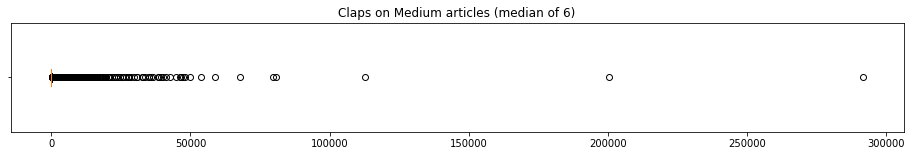

In [ ]:
boxplot(train_target, f'Claps on Medium articles (median of {int(np.median(train_target))})')

239 out of 66380 train observations with more than 5849 claps were dropped.

0 claps: 31 % of articles in the train dataset 
1:        8 % 
2:        3 % 
3-10:    11 % 
11-100:  24 % 
100+:    18 %


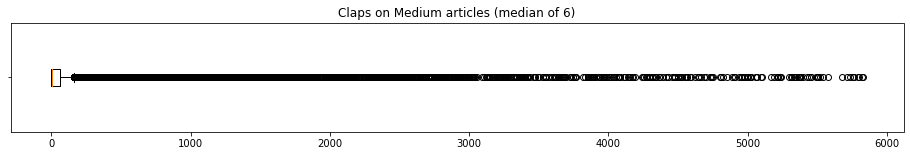

In [ ]:
replacer = ReplaceOutliers(par=3)
target_ub = replacer.find_ub(train_target)
keep_idx = train_target <= target_ub

train_target2 = train_target[keep_idx]
train2 = train[keep_idx]

claps_counts = train_target2.value_counts(normalize=True) * 100


boxplot(train_target2, f'Claps on Medium articles (median of {int(np.median(train_target))})')


print(f'{sum(train_target > target_ub)} out of {len(train_target)} train observations '
      f'with more than {target_ub} claps were dropped.\n\n'
      f'0 claps: {int(claps_counts[0])} % of articles in the train dataset \n'
      f'1:        {int(claps_counts[1])} % \n'
      f'2:        {int(claps_counts[2])} % \n'
      f'3-10:    {int(sum(claps_counts[3:11]))} % \n'
      f'11-100:  {int(sum(claps_counts[12:101]))} % \n'
      f'100+:    {int(sum(claps_counts[101:]))} %'
     )

After removing the extreme outliers, the distribution of __Claps__ still appears to be extremely left-skewed, with 75% articles having less than the average number of claps.

This suggests the following potential problems for the later modeling:

* Data points (Medium articles) with a relatively high number of claps will unproportionally contribute to the model loss, should MSE be used for optimization;
* Neural networks may learn to optimize the loss in a way that they always predict a value around the mean/median rather than actually learning from the data features;
* Depending on the choice of the evaluation metric, a model always predicting the train mean (or some other arbitrary metric-optimizing value) may outperform more sophisticated models.

In other words, predicting claps is a non-trivial task, as it will be proven later in this notebook.

### Numeric features

In [14]:
NAs = train_present.isna().sum()
NAs.name = 'missing'
train_present.describe().append(NAs)

#test.isna().sum() # few Mediums are missing, the rest is 0

,SincePublished,Responses,Images,Links,Length,Readability,Claps,Author,Medium,Text,Title
count,66141,66141,66141,66141,66141,66141,66141,nan,nan,nan,nan
mean,218,1,4,7,5455,14,111,nan,nan,nan,nan
std,118,3,5,11,5083,35,375,nan,nan,nan,nan
min,3,0,0,0,0,-16,0,nan,nan,nan,nan
25%,119,0,1,1,2503,10,0,nan,nan,nan,nan
50%,207,0,2,4,4290,12,6,nan,nan,nan,nan
75%,309,0,4,8,6850,14,64,nan,nan,nan,nan
max,1874,342,263,1180,143709,4304,5828,nan,nan,nan,nan
missing,0,0,0,0,0,0,0,0,35270,0,0


Numeric features may potentially have explanatory power with regard to how well an article is perceived by the audience: if an article was just recently published and has only few respones, it likely did not have many readers and did not receive many claps (likes) yet. The length of text (here: in characters, later in the analysis: in words), the amount of images and links it exhibits may provide some additional information if the audience interacts differently with different types of articles.

The consequent boxplots compare distributions of numeric features between train and test data. The most important takeaway from the visual exploration is that all features are heavily left skewed and have a considerable number of outlying values. To reduce noise in the data, these values will be truncated at a later point when splitting the current train dataset into 'train' and 'test' data for modeling.

Distributions of values in train and test data are relatively similar for __Responses__, whereas they noticeably vary for other features. While handling outliers will partially solve this issue, it is possible that no truly successful extrapolation of patterns in the train data onto test data will be possible.

Nonetheless, one good thing is that missing values are not an issue for the current data (except for 'Medium' which is a categorical variable and which, after a careful consideation, won't be used in the modeling) 

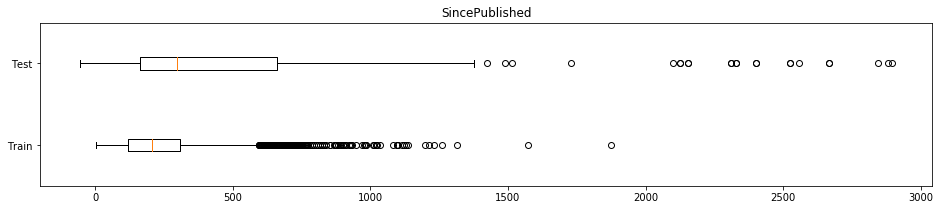

In [37]:
n = 'SincePublished'
boxplot([train[n], test[n]], n)

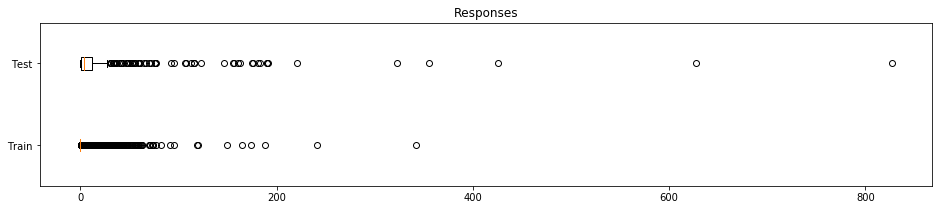

In [33]:
n = 'Responses'
boxplot([train[n], test[n]], n)

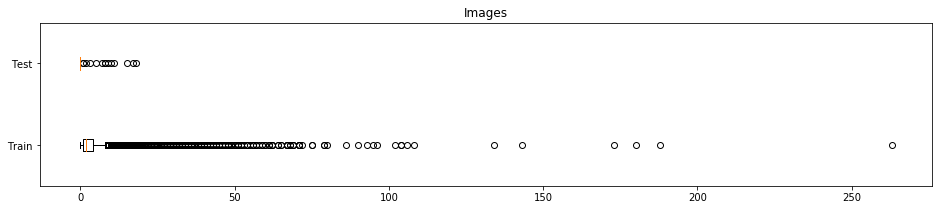

In [34]:
n = 'Images'
boxplot([train[n], test[n]], n)

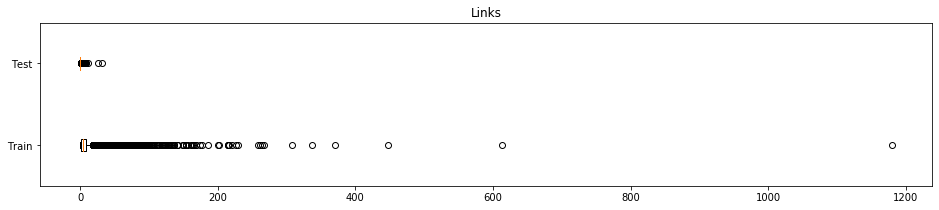

In [35]:
n = 'Links'
boxplot([train[n], test[n]], n)

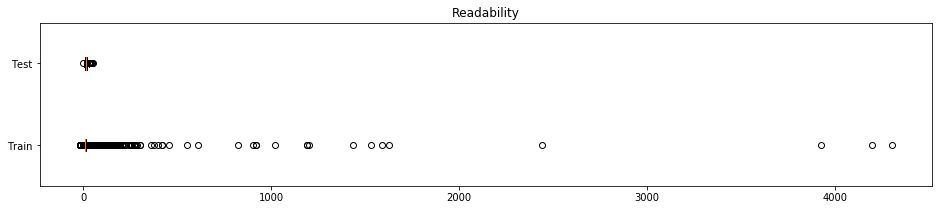

In [36]:
n = 'Readability'
boxplot([train[n], test[n]], n)

### Categorical features

Certain authors and Medium categories (let's refer to them as Mediums) are likely to be more popular and likable than others. As no author-specific information (such as number of followers) is provided in the test data, one may want to learn this information from the train data. 

Is this feasible? Not necessarily, given that only 20% of authors and 37% of mediums present in test data are also present in train (see below). Subsetting authors/mediums that are more common did not lead to improvements in these ratios. 

Hence, features __Author__ and __Medium__ will not be used in the further analysis.

In [ ]:
total = len(test['Author'].unique())
count = len([1 for a in test['Author'].unique() if a in train2['Author'].unique()])

print(f'Out of {total} authors in test data, {round(count/total*100, 2)} % are present in train data.')


total = len(test["Medium"].unique())
count = len([1 for a in test['Medium'].unique() if a in train2['Medium'].unique()])

print(f'Out of {total} mediums in test data, {round(count/total*100, 2)} % are present in train data.')

Out of 214 authors in test data, 19.63 % are present in train data.
Out of 101 mediums in test data, 36.63 % are present in train data.


In [ ]:
# save everything we have done so far:

with open(DIR + 'df_clean.pkl', 'wb') as f:
    pickle.dump([train_target2, train2, test], f)
print('Saved locally.')


# delete some objects that we don't need anymore:
del test_raw, train_raw, train, train_target, train_present, claps_counts

## Words, words, words

So far, textual features have only been partially prepared. It is finally time to further clean out textual data and prepare tokens. Different to the simpler and a somewhat more intuitive approach using tools of the [NLTK](https://www.nltk.org/) package, we will instead rely on the powerful [spaCy](https://spacy.io/) library.

![doge](https://drive.google.com/uc?export=view&id=1ZRWtshPQgfQvnGBUrI7ZtQCQ2hHSEknM)
_(Figure: Strong dog vs. weak dog meme in the context of NLP. Source: own illustration, imgflip.com for the template)_

With NLTK, the [regular workflow](https://machinelearningmastery.com/clean-text-machine-learning-python/) is iterative: one first splits each document into sentences, then into words, then removes punctuation, stop words, stems or lemmatizes the remaining words, etc. In a way, the workflow is such that one iterates over all documents, solving only one subproblem in each step.

With spaCy, the [processing pipeline](https://spacy.io/api#architecture-pipeline) happens under the hood of one function, `spacy.nlp()`, ultimately resulting in a much more elegant code. Depending on the selected options, it processes the input text, identifying words, parts of speech they represent and their relationships within the sentence. A resulting __Doc__ represents a sequence of annotated __Token__s, one for each identified word, space, punctuation mark, or any other part of the original sentence. The annotations included in the token include a wide range of attributes, such as its lemmatized form, its vector (if available), a boolean identifying whether it represents a word on the stop list, a digit, or some other sentence member (see [all attributes](https://spacy.io/api/token#attributes)). 

SpaCy comes with a choice of [pretrained statistical language models](https://spacy.io/models). The model used in the current analysis, `en_core_web_lg`, was trained on the manually-annotated [OntoNotes](https://catalog.ldc.upenn.edu/LDC2013T19) corpus and comes with 686k [Common Crawl GloVe](https://nlp.stanford.edu/projects/glove/) built-in vectors (300 dimensions). 

Ironically, while many Medium.com articles discuss machine learning and blockchain technologies, the related
technical jargon is not known to the spaCy model. A selection of terms (e.g. 'deepfake') and entity names ('tensorflow') that occur most often has been therefore manually added to the model corpus.
 
To process all operations on text in a tidy and pythonic manner, a custom class, `Tokenizer2`, was designed building upon the spaCy nlp-pipeline. Several parameters, such as whether out-of-vocabulary words have to be kept in the output, can be defined upon initiation of a class instance. The text processing workflow applied for the current task is summarized in the following.

__Basic cleaning of text__ (already done):
* Removing html-tags, unicode signs, line breaks, and parantheses (the latter is required to avoid errors when applying `re.sub()` function in the next step;
* Removing textual information that belongs into other columns, e.g. removing author name from the text.


__Tokenizer2 workflow__:
* Limiting input length of an article to 5000 characters (median length is 4300) to speed up things a bit;
* Removing capitalization (This is not strictly necessary when working with spaCy as it should be able to distinguish between apples and Apple. As sample testing has shown, this functionality did not perfectly work on the current dataset);
* Fixing contractions (I'm -> I am; done automatically by spaCy);
* Splitting documents into words;
* Preserving sentence structure (with dots between all original sentences) to use it later on for transformers;


* Removing all non-textual tokens (e.g. numbers);
* Removing all out-of-vocabulary words (e.g. non-English words, misspelled words, etc.);
* Lemmatizing words based on their parts of speech.

__Tokenizer2 outputs__:
* For each article, a list of tokens (having removed all non-desired tokens);
* For each article, its length in words;
* Vectorized representation of all articles with dimensions (N articles x 100 first tokens x 300 token dimensions) and a reduced precision level (float16). _Limiting precision level and the number of tokens was not a simple choice but was required to ensure that the resulting numpy array does not cause memory issues at none of the consequent steps;_
* As well as two dictionaries with counts of words used in articles and of removed out-of-vocabulary words.


__Example of the Tokenizer2 functionality:__

In [3]:
## EXAMPLE:

tokenizer_example = Tokenizer2(keep_oov=False, to_lower=False, preserve_sentences=True,
                               corpus_path=None)

temp = tokenizer_example.tokenize(['Interestingly, this is a pretty great sentence. About how all employees ' + 
                                  'at Apple get free and great apples every THIRD EVENING. ' + 
                                  'https://hu-berlin.de Please buy my Bitcoin 12345 ' +
                                  'ik hou van je, длинношеее животное'])

print(f'\nTokenized and lemmatized: \n{words_to_docs(temp[0], drop_dots=False)} \n\n'
      f'Vector representation has dimensions {temp[1].shape} \n\n'
      f'Corpus (words in our texts): {tokenizer_example.corpus} \n\n'
      f'Out of spaCy vocabulary and removed: {tokenizer_example.oov} \n\n'
      f"SpaCy's stop list has {len(tokenizer_example.nlp.Defaults.stop_words)} stop words."
)


## we can save oov words for a more careful review to a csv:
#pd.DataFrame(sort_dict(tokenizer_example.oov).items()).to_csv(DIR + 'oov.csv')

## should we add some words? (relevant only if keep_oov=False)
#oov_add = ['cryptocurrency']
#tokenizer_example.add_to_vocab(oov_add)

#tokenizer_example.add_to_stop(['someStopWord'])

## (re-)training feature recognition:
# https://spacy.io/usage/linguistic-features#updating

del tokenizer_example

Tokenizer initiated. No corpus was pre-loaded.
1 documents tokenized and prepared in 0 seconds.

Tokenized and lemmatized: 
['interestingly pretty great sentence. employee Apple free great apple evening. buy Bitcoin ik hou van je'] 

Vector representation has dimensions (1, 300, 300) 

Corpus (words in our texts): {'interestingly': 1, 'pretty': 1, 'great': 2, 'sentence': 1, '.': 2, 'employee': 1, 'Apple': 1, 'free': 1, 'apple': 1, 'evening': 1, 'buy': 1, 'Bitcoin': 1, 'ik': 1, 'hou': 1, 'van': 1, 'je': 1} 

Out of spaCy vocabulary and removed: {'https://hu-berlin.de': 1, 'длинношеее': 1, 'животное': 1} 

SpaCy's stop list has 326 stop words.


The preceding example illustrates some strengths but also certain limitations of spaCy:

Lemmatization seems to work fine, and the tokenizer could tell the difference between apples and Apple. It removed all unnecessary stop words, a link and two Russian words. Nonetheless, it failed to remove a Dutch sentence. This implies one of the two possible errors: either these words have Glove vectors (although they should not) or spaCy connects these words to some other English words that have Glove vectors (although it should not, as these are clearly non-English words). 
This is a fairly nice reminder that natural language processing requires a lot of fine-tuning and always comes with a certain degree of errors.


### Process texts from train and data:

Let us process all articles in train and test datasets using `Tokenizer2`. To reduce memory usage, number of tokens in vector representations and their precision level will be limited as it was already discussed previously.

Titles and texts will be concatenated to create one text for each article. This approach implies some further information loss, and there are ways how this could have been handled differently, e.g. by keeping two features, which can then for example be used to extract distinct new features from the title and the text. 

After articles were processed, their tokenized representations (in form of lists of strings) will be stored in the train and test dataframes, whereas numpy arrays with vector representations will be stored externally.
The vector representation of the train data, limited to 100 tokens per article and with a reduced rounding precision (*float16*), has dimensions (66141, 100, 300) and weights more than 4 GB.

In [8]:
with open(DIR + 'df_clean.pkl', 'rb') as f:
    train_target2, train2, test = pickle.load(f)
print('Loaded from local storage.')

Loaded from local storage.


In [ ]:
tokenizer = Tokenizer2(keep_oov = False, # removes non-words
                       to_lower = True, # strictly speaking not necessary when using spaCy vectors
                       preserve_sentences = True, # useful for transformers
                       # to improve speed and limit memory usage:
                       limit_length = 5000,  # trucatenates long input articles
                       max_tokens = 100,      # reduced nr. of tokens for vector representation
                       precision = 'float16', # reduced precision for vector representation
                       corpus_path = DIR + 'corpus.pkl')

STOPWORDS = ['te', 'food']
GOODWORDS = ['tensorflow', 'jupyter', 'kaggle', 'pytorch', 'udacity', 'scikit', 'lstm' 'gdpr',
             'udemy', 'openai', 'fast.ai', 'lstm', 'scikit', 'cryptocurrencie', 'ethereum', 
             'word2vec', 'deeplearning', 'blockchain', 'legaltech', 'neurotechnology', 'deepfakes', 
             'heteroscedasticity']

# spaCy has no good knowledge of ML and crypto topics that are quite popular on Medium.com
# we will add these words to vocabulary so that they don't get removed
# the word 'naïve' that is so beloved by The New Yorker is also not known by spaCy

tokenizer.add_to_stop(STOPWORDS)
tokenizer.add_to_vocab(GOODWORDS)

Tokenizer initiated. No corpus was pre-loaded.
2 words added to stop words.
21 words added to vocabulary. Note that they have zero vector representations.


In [ ]:
words = {}
word_vectors = {}
word_lengths = {}

texts_to_process = ['test', 'train']


for idx, t in enumerate(texts_to_process):
    
    if idx==0: x = test['Title'] + '. ' + test['Text']
    if idx==1: x = train2['Title'] + '. ' + train2['Text']
    
    words[t], word_vectors[t], word_lengths[t] = tokenizer.tokenize(x, to_disc='tokens3/'+ t +'.pkl')


514 documents tokenized and prepared in 31 seconds.
Saved locally.
66141 documents tokenized and prepared in 4243 seconds.
Saved locally.


In [ ]:
# Update textual information in datasets with tokens (NOT with texts!)

test['Text'] = words['test']
train2['Text'] = words['train']

test['Words'] = word_lengths['test']
train2['Words'] = word_lengths['train']

In [ ]:
# Drop columns that we will no longer use:

drop_cols = ['Title', 'Medium', 'Author']

train2.drop(drop_cols, axis='columns', inplace=True)
test.drop(drop_cols, axis='columns', inplace=True)

In [ ]:
## backup everything we have done so far:
with open(DIR + 'ready_for_analysis.pkl', 'wb') as f:
    pickle.dump([train_target2, train2, test, word_vectors], f)
print('Saved locally.')

Saved locally.


### Review results:

In [ ]:
print(f"Vectorized representation of the train dataset has dimensions {word_vectors['train'].shape}.")

train2.tail()

Vectorized representation of the train dataset has dimensions (66141, 100, 300).


,SincePublished,Responses,Images,Links,Text,Words
279552,304,1,5,9,"[uc, berkeley, mids, immersion, fall, ., danie...",443
279557,181,1,13,16,"[analyze, extreme, skiing, snowboarding, r, fr...",440
279567,145,0,5,16,"[build, smart, chatbot, assistant, ibm, watson...",395
279570,342,0,3,3,"[thing, crowded, ., useful, label, text, data,...",135
279572,228,0,1,9,"[london, create, ethic, panel, evaluate, use, ...",442


In [ ]:
# a sample article:
words_to_docs([train2['Text'].iloc[1900]], drop_dots=False) # looks good!

['machine learn apply human. image source. shutterstock siri. google receive word smiley suggestion whatsapp google allo. yes familiar concept machine learning. forgive terminator fan muggle need introduction machine learning. muggles. machine learning give machine ability learn perform well programming teach perform well. confuse. let try consider scenario scenario. buy new mobile phone amazon. week later receive phone. decide buy phone cover. open amazon app search phone cover buy. scenario visit buy mobile phone. check feature suggestion phone cover. buy phone cover. convenient. scenario right. time log probably suggest cool accessory phone. machine learn. case system pull data profile surfing habit purchase history. special analyse give recommendation great shopping experience. word keep learn improve perform well tell. machine learning life. recommendation website like youtube amazon etc intelligent assistant like siri google. application. million dollar question apply human. lear

### Distribution of words

Articles in the examined datasets (both test and train) have almost 82k unique words, of which 50% occur less than 4 times. The distribution is extremely left-skewed, with less than 1% of words occuring more than 10k times (remember, we have more than 60k articles). What are the most popular words?

_Data_ (300k occurences), _AI_ (176k), _machine ... learning_ (119k and 102k), _time_ (100k), _model_ (98k), and _learn_ (93k).

This clearly signals that a lot of articles are about machine learning and data analysis. Sadly, these are also the topics for which some (many?) of the technical terms don't have pre-trained Glove vectors, therefore making the job for our future algorithms more complicated.

One other issue becoming clear from these few words is that bi-grams, such as _machine learning,_ may potentially be useful for modeling. This said, such a potential enhancement will remain out of the scope of this notebook.

count     81708
mean        272
std        8337
min           1
25%           1
50%           4
75%          20
max     2278139
dtype: float64


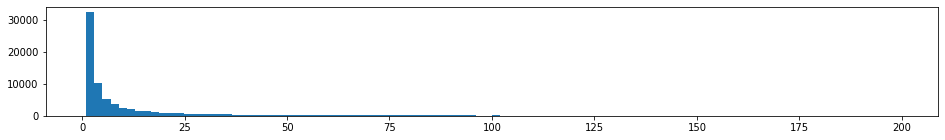

In [ ]:
words_counts = tokenizer.corpus.values()

fig = plt.figure(1, figsize=(16, 2))
fig = plt.hist([x for x in words_counts if x < 200], bins=100)

print(pd.Series(list(words_counts)).describe())

#np.sum(pd.array(list(words_counts)) > 10000) # 400 words occur more often than 10k times, it's 0.005%

In [ ]:
sort_dict(tokenizer.corpus)
#sort_dict(tokenizer.oov) # out-of-vocabulary

{'.': 2278139,
 'data': 303235,
 'ai': 176132,
 'machine': 119192,
 'learning': 102205,
 'time': 100270,
 'model': 98812,
 'learn': 93424,
 'use': 91640,
 'like': 90649,
 'work': 86374,
 'new': 81930,
 'human': 80665,
 'need': 80062,
 'technology': 76520,
 'intelligence': 71872,
 'way': 62985,
 'create': 61335,
 'system': 60301,
 'good': 60000,
 'artificial': 59554,
 'company': 59516,
 'people': 59476,
 'network': 57763,
 'user': 57394,
 'business': 57098,
 'image': 54462,
 'know': 54132,
 'help': 53397,
 'find': 51323,
 'world': 51131,
 'algorithm': 50310,
 'build': 50258,
 'base': 50224,
 'example': 49978,
 'year': 49170,
 'customer': 49063,
 'look': 48139,
 'value': 48069,
 'problem': 47756,
 'process': 47714,
 'start': 47525,
 'set': 46204,
 'want': 45698,
 'information': 44854,
 'deep': 44476,
 'science': 42718,
 'come': 41999,
 'thing': 41615,
 'different': 41517,
 'think': 40901,
 'product': 40234,
 'service': 39215,
 'feature': 39208,
 'change': 38784,
 'result': 38545,
 'provi

### Length of articles in words

Length of articles in words is another (extracted) feature that we can further use for the analysis. Some simple summary statistics are reported below.

_NOTE/LIMITATION: Reported article lenghts are after input texts for the tokenizer were truncated to 5000 characters._

In [ ]:
print(f'Article length: \n'
      f'- train: {min(train2["Words"])} ... mean: {int(np.mean(train2["Words"]))} .. {max(train2["Words"])} \n'
      f'- test:  {min(test["Words"])} ... mean: {int(np.mean(test["Words"]))} .. {max(test["Words"])} \n')

Article length: 
- train: 0 ... mean: 333 .. 755 
- test:  5 ... mean: 276 .. 481 



In [ ]:
del train_target2, train2, test

---
# MODELING

Before moving on with the actual search for the "best" model, let us first define how the performance is to be measured.

__Performance evaluation__:

The majority of articles have a relatively small number of claps, which is likely to be mirrored by the range of predictions turning out to be lower than the range of true values. If the prediction algorithm is to be used as a business application, one may want to punish prediction errors for articles with a low number of claps in a different way than for the more successful articles. 

When using the most commonly applied regression metric, the *Mean Square Error* (MSE), the error is quadratically increasing with the size of the prediction error. As such, an article with 10000 true likes and 5000 predicted will have a MSE _much_ higher (5000^2) than an article with 5 true likes and 50 predicted (45^2). For the extremely left skewed target feature, MSE would deliver a strongly biased evaluation of model performance. (At the same time, when trying different modeling approaches, MSE has proven to perform as the best model loss.)

*Mean Absolute Error* (MAE) offers a better interpretability of model performance by answering the question "What is the average deviation of the prediction from true values?". Yet it is also biased towards larger values and does not provide a balanced view on the model performance. 

Hence, a weighted metric could be an appropriate solution for the problem at hand. A *weighted MAE* with the weight equal to $\frac{1}{true_i + 1}$ will assign relatively higher errors to low true values and relatively lower errors to high true values, so that data distribution is directly accounted for when evaluating the prediction accuracy. For the examplary articles used above, the article with 10000 true likes and 5000 predicted will be assigned an error of 0.5 only whereas the article with 5 true likes and 50 predicted will receive an error of 7.5. In other words, this metric requres higher prediction accuracy for the vast majority of articles with lower number of claps rather than for the more successful articles.

None of the metrics discussed so far provide a fair insight into whether the model has any explanatory value. We will use the *R2 statistic* as an additional criteria for model evaluation. Different to the (classic) linear regression, R2 for neural networks is not bound to the range between 0 and 1, it can also be indefinitely less than zero, indicating that the model has less explanatory value than a mean value prediction.

Given that the MSE will be used as model loss, using a mixture of the wMAE and R2 to evaluate model performance will act as a somewhat independent model audit. 

**Performance metrics:**

$\text{MSE} = \frac{1}{n} \sum{(true_i - predicted_i)^2}$

$\text{MAE} = \frac{1}{n} \sum{|true_i - predicted_i|}$

$\text{wMAE} = \frac{1}{n} \sum{\frac{|true_i - predicted_i|}{1 + true_i}}$

$r^2 = \frac{\text{explained variance}}{\text{total variance}}$

## Preparing for modeling

It is finally time to split the original "train" dataset into train and test (25%) data for the modeling. 

Upper bound outliers in numeric variables will be replaced using the custom `ReplaceOutliers` class based on the mean of the train data plus three standard deviations ([Three-Sigma-Rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

An instance of another custom class, `Models`, will serve as a place to store computed predictions and performance evaluations of all fitted models.

For all models, negative predictions (if any) will be replaced with zeroes.

In [47]:
#################
#TESTING = True
TESTING = False
#################

from sklearn.model_selection import train_test_split
replacer = ReplaceOutliers() # this one is customly defined


# load data created previously:
with open(DIR + 'ready_for_analysis.pkl', 'rb') as f:
    train_target3, train3, test3, word_vectors = pickle.load(f)
print('Loaded from local storage.')


# reset indexes
train3.reset_index(drop=True, inplace=True)
train_target3.reset_index(drop=True, inplace=True)


# make small subset for testing:
if TESTING is True:
    drop1, train3, drop2, train_target3 = train_test_split(train3, train_target3, 
                                                           test_size=0.1, random_state=1825)
    print('USING SMALL SUBSET ONLY')


# split data into train and test:
X_train, X_test, y_train, y_test = train_test_split(train3, train_target3,
                                                    test_size=0.25, random_state=1825)

# replace outliers:
print('Replacing outliers in train data:')
X_train = replacer.fit_transform(X_train)
print('\nReplacing outliers in test data:')
X_test = replacer.transform(X_test)


#split text into train and test:
W_train = word_vectors['train'][X_train.index,]
W_test = word_vectors['train'][X_test.index,]

print(f'\nTrain dataset has {X_train.shape[0]} articles and test {X_test.shape[0]}.')
print(f'Train vectorized texts have dimensions {W_train.shape} and test {W_test.shape}.\n')


# save:
with open(DIR + 'data_for_modeling.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test, W_train, W_test], f)
print('Saved locally.\n')

# save to use the same parameters for the final prediction:
with open(DIR + 'replacer_ub.pkl', 'wb') as f:
    pickle.dump(replacer.ub, f)

Loaded from local storage.
Replacing outliers in train data:
SincePublished: 3582 values replaced with the upper bound of 396
Responses: 969 values replaced with the upper bound of 6
Images: 2342 values replaced with the upper bound of 12
Links: 1734 values replaced with the upper bound of 25
Length: 2939 values replaced with the upper bound of 13059
Words: 80 values replaced with the upper bound of 538
Readability: 344 values replaced with the upper bound of 66

Replacing outliers in test data:
SincePublished: 1277 values replaced with the upper bound of 396
Responses: 338 values replaced with the upper bound of 6
Images: 813 values replaced with the upper bound of 12
Links: 565 values replaced with the upper bound of 25
Length: 970 values replaced with the upper bound of 13059
Words: 24 values replaced with the upper bound of 538
Readability: 97 values replaced with the upper bound of 66

Train dataset has 49605 articles and test 16536.
Train vectorized texts have dimensions (49605, 

In [256]:
# re-load if required:
with open(DIR + 'data_for_modeling.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test, W_train, W_test = pickle.load(f)
print('Loaded from local storage.')

Loaded from local storage.


In [257]:
NUMVARS = ('SincePublished', 'Responses', 'Images', 'Links', 'Words', 'Readability')
TEXTVARS = ('Text')

models = Models(true_train = y_train, true_test = y_test)

In [291]:
# using this cell to save intermidiary results every now and then...

#models.save(DIR + 'MODELS_30aug.pkl')

Saved locally.



## 1. Benchmarks: train mean / median

To start with, two simple benchmarks: predicting all values equal to the mean (110) and median (6 claps) of the train data. By definition of R2, the former will have R2 equal zero. 

Noticeably, if evaluating models only by the wMAE, no model will be able to beat the median prediction. Nonetheless, it is no good model according to a negative R2 statistic.

In [258]:
train_mean = int(np.mean(y_train))
print(f'Train dataset has {train_mean} claps on average.\n')

models.add(
    name = 'train_mean',
    model = train_mean,
    pred_train = np.full((1, len(y_train)), train_mean).reshape(-1,),
    pred_test = np.full((1, len(y_test)), train_mean).reshape(-1,)
)

#models.visualize('train_mean')

Train dataset has 110 claps on average.

wMAE - train: 108.99, test: 109.01. Current rank: 1 
mae  - train: 153.56, test: 154.88
mse  - train: 136817.41, test: 150765.29
r2   - train: -0.0, test: -0.0


In [259]:
train_median = int(np.median(y_train))
print(f'Train dataset has {train_median} claps on average.\n')

models.add(
    name = 'train_median',
    model = train_median,
    pred_train = np.full((1, len(y_train)), train_median).reshape(-1,),
    pred_test = np.full((1, len(y_test)), train_median).reshape(-1,)
)

Train dataset has 6 claps on average.

wMAE - train: 6.49, test: 6.47. Current rank: 1 
mae  - train: 109.66, test: 110.41
mse  - train: 147736.1, test: 161819.38
r2   - train: -0.08, test: -0.07


## 2. No textual data considered: linear regression

A simple model to start with: a linear regression on the 6 numeric features, which are standardized by removing the mean and scaling them to unit variance.

In [239]:
print(NUMVARS)

('SincePublished', 'Responses', 'Images', 'Links', 'Words', 'Readability')


In [260]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def passthrough(doc):
    return doc

def removedots(doc):
    return [t for t in doc if t != "."]

def nonnegative(a):
    return np.where(a<0, 0, a)


selector = ColumnTransformer([('selector', 'passthrough', NUMVARS)], remainder='drop')
scaler = StandardScaler()
reg = LinearRegression()

pipe2 = Pipeline([('var_selector', selector),
                  ('scaler', scaler), 
                  ('regressor', reg)])

models.time()
models.add(
    name = 'no_text',
    model = pipe2.fit(X_train, y_train),
    pred_train = nonnegative(pipe2.predict(X_train)),
    pred_test = nonnegative(pipe2.predict(X_test))
)

wMAE - train: 26.9, test: 26.77. Current rank: 2 
mae  - train: 105.43, test: 105.33
mse  - train: 82177.71, test: 89891.34
r2   - train: 0.4, test: 0.4
Elapsed: 0 seconds.


no_text - train: 0 .. 111 .. 1303
no_text - test: 0 .. 110 .. 1302


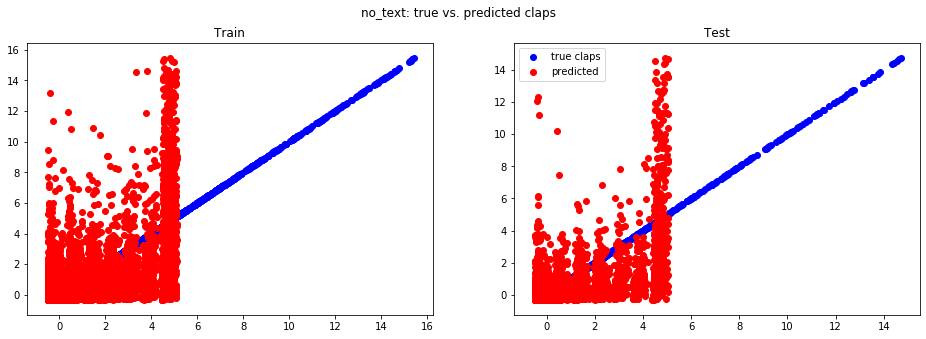

In [261]:
models.distr('no_text')
models.visualize('no_text', zscores=True)

As it was expected, range of predicted values is less than the actual range of true claps. This simple model reaches a relatively good R2 value of 40% but, judging by the plots above, it does not really learn much about the data structure. Would these results improve if we add some naive representation of the textual data?

## 3. Lasso regression: numeric + Tf-Idf Text

In addition to standardized numeric features, this model accepts a tf-idf normalized bag-of-word. In other words, for each article, frequency of each occuring word is calculated and weighted against the inverse of its frequency in all of the articles. 

The final layer of the model is a penalized Lasso regression, which shrinks coefficients of non-relevant features to zero. (It has performed better than Ridge and Elastic Net regressions; I acknowledge that I did not invest much time into their fine-tuning, so that better results than with Lasso could have been theoretically achieved).

Schematically, the model can be represented as follows:

![lasso](https://drive.google.com/uc?export=view&id=1IawiDGwSQHS23-BaS6Z40bIA_FWkhrFY)

In [328]:
# Numeric variables > Normalization             ) > Lasso
# Text > Vectorization > Tf-Idf transformation  )

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

def passthrough(doc):
    # https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer
    return doc

def removedots(doc): 
    # we only need these dots for transformers, not here
    return [t for t in doc if t != "."]


bow_vector = CountVectorizer(min_df=10, ngram_range=(1,1),
                             tokenizer=removedots, preprocessor=passthrough)

tf_idf_vector = TfidfTransformer()
scaler = StandardScaler()
lasso = Lasso(max_iter=1000)


textual_pipe = Pipeline([('vectorizer', bow_vector), ('normalizer', tf_idf_vector)])

preparation = ColumnTransformer([('text', textual_pipe, TEXTVARS), 
                                 ('num', scaler, NUMVARS)],
                                remainder ='drop')

In [329]:
pipe3 = Pipeline([('preparation', preparation), ('regressor', lasso)])

models.time()
models.add(name = 'lasso_all',
           model = pipe3.fit(X_train, y_train),
           pred_train = nonnegative(pipe3.predict(X_train)),
           pred_test = nonnegative(pipe3.predict(X_test))
)

wMAE - train: 27.07, test: 26.93. Current rank: 5 
mae  - train: 105.3, test: 105.19
mse  - train: 82191.68, test: 89917.98
r2   - train: 0.4, test: 0.4
Elapsed: 44 seconds.


lasso_all - train: 0 .. 110 .. 1294
lasso_all - test: 0 .. 110 .. 1294


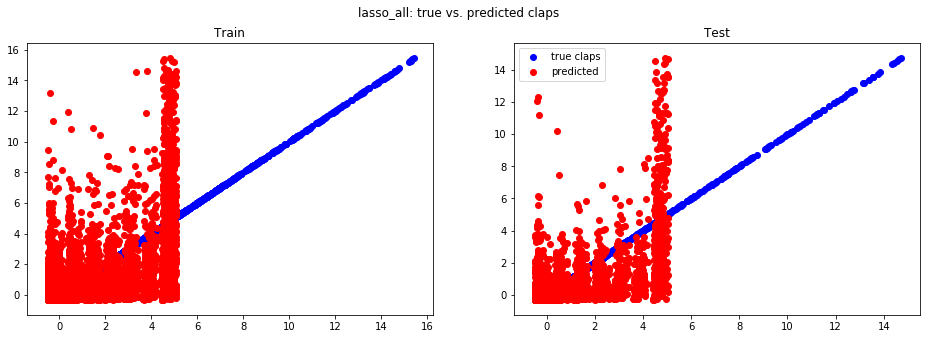

In [264]:
models.distr('lasso_all')
models.visualize('lasso_all', zscores=True)

Well, it was worth a try. The results are very similar to the ones of the linear regression without any text knowledge, and no evidence for an improvement can be found based on the plots or performance metrics. 

## 4. Random forest

This model follows the intuition of the previous one, replacing the final step in the pipeline with a random forest.

![rf](https://drive.google.com/uc?export=view&id=1AkxFIpjeRQxew-crkQSTBarZKGrU7-6f)

In [23]:
# Numeric variables > Normalization             ) > RandomForest
# Text > Vectorization > Tf-Idf transformation  )

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)

pipe4 = Pipeline([('preparation', preparation), ('regressor', rf)])

models.time() # ca. 8 min per tree when running locally
models.add(name = 'rf_all',
           model = pipe4.fit(X_train, y_train),
           pred_train = pipe4.predict(X_train),
           pred_test = pipe4.predict(X_test)
)

wMAE - train: 12.11, test: 33.5. Current rank: 2 
mae  - train: 39.36, test: 101.89
mse  - train: 14245.76, test: 85368.65
r2   - train: 0.9, test: 0.43
Elapsed: 5264 seconds.


rf_all - train: 0 .. 109 .. 5186
rf_all - test: 0 .. 109 .. 3464


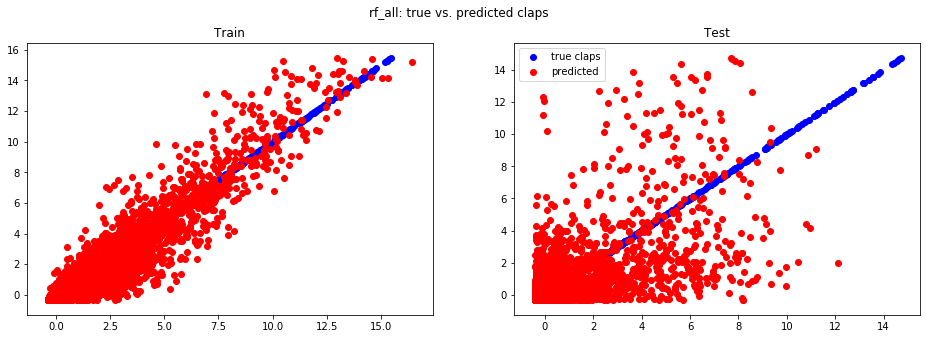

In [268]:
models.distr('rf_all')
models.visualize('rf_all', zscores=True)

Sadly, the random forest without further adjustments is overfitting the train data. Nonetheless, there is some evidence that it is capable of understanding data structure better than regression algorithms, reaching a somewhat higher R2 and lower MAE and MSE.

Possibly, fine-tuning the random forest and its impurity as well as growing more trees may significantly improve results and make it the best-performing model. For the given data, this can be relatively expensive, as e.g. growing 100 trees would take ca. 13 hours without parallelization (which is not fully implemented in sklearn).

Instead, we will focus on neural networks.

## 5. CNN

As already discussed in the lecture in great detail, convolutional neural networks (CNN) offer a state-of-art solution when it comes to recognition of image patterns. They can as well be applied to learn patterns in natural language, and in my personal opinion they offer a much more elegant and intuitive solution to such problems in terms of model design compared to LSTM and RNN, which historically are a more common choice for NLP tasks.

Hence, the following several models will utilize different CNN architectures in an attempt to learn more information from the textual data from Medium.com articles to improve the prediction quality. As a first inspiration, I am following the modeling approach of [Zhang & Wallace 2015](https://arxiv.org/pdf/1510.03820.pdf), who use 2 filters of size 2, 3, and 4 words, which are then passed through a max pooling layer and concatenated with one other before being passed on to a classification layer.

As it can be seen on the diagram below, the selected design of the model differs in many ways. Selected filter sizes range from 1 to 4 words, and for each filter size there exist 5 filters. The idea behind this is to learn more patterns in data that may have an impact on the popularity of the article resulting in more claps. The output of the CNN layers is then concatenated, passed through a global max pool layer to reduce dimensionality, and passed through a dropout layer (droupout rate of 0.5) to prevent model overfitting. In the next step, data is pased through a 5 filter dense layer and another dropout layer before the final prediction is fitted in a 1-filter dense layer with a linear activation. 

![cnn5](https://drive.google.com/uc?export=view&id=1IQlc0bWy8aNyPekJEACB-wnWHBr2ICh6)

A choice of other architectures was examined, however, these models did not reach acceptable results and are therefore not reported in this notebook.

Having prepared vectorized text representations (Glove embeddings) while preparing textual data with spaCy, the process of training CNNs is surprisingly trivial and quick, with ca. 1.2 minutes per epoch. Nonetheless, for the current data (with reduced precision level and only 100 words per article) it requires more than 12 GB of RAM, so that training can't be performed using the free Colab version.

In [92]:
import keras
from keras import layers

# model partially follows Zhang & Wallace 2015
# https://cloud.githubusercontent.com/assets/11842615/25828679/df9dc5c6-3451-11e7-9792-c8fa32dd920f.png

n_filters_conv = 5
n_filters_dense = 5
droupout_rate = 0.5


# convolutional part with varying filters:
conv_input = keras.Input(shape=(100, 300), name="doc")
conv_layer = []

for filter_size in (1, 2, 3, 4):
    c = layers.Conv1D(n_filters_conv, filter_size, 
                      padding='same', 
                      activation='relu', 
                      name=f'conv_{filter_size}_{n_filters_conv}')(conv_input)
    conv_layer.append(c)

# concatenate:
c = layers.Concatenate(name=f'concatenate_to_100x{n_filters_conv*3}')(conv_layer)
c = layers.GlobalMaxPooling1D(name=f'max_pool_to_{n_filters_conv*3}')(c)

# dense layers:
c = layers.Dropout(droupout_rate, name='dropout')(c)
c = layers.Dense(n_filters_dense, activation='relu', name=f'dense_to_{n_filters_dense}')(c)
c = layers.Dropout(droupout_rate, name='dropout2')(c)
c = layers.Dense(1, activation='linear', name='dense_to_1')(c)

# build model:
cnn5 = keras.Model(conv_input, c, name='cnn5')
cnn5.compile(loss='mean_squared_error')

cnn5.summary()
#keras.utils.plot_model(cnn5, show_shapes=False)

Model: "cnn5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
doc (InputLayer)                [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv_1_5 (Conv1D)               (None, 100, 5)       1505        doc[0][0]                        
__________________________________________________________________________________________________
conv_2_5 (Conv1D)               (None, 100, 5)       3005        doc[0][0]                        
__________________________________________________________________________________________________
conv_3_5 (Conv1D)               (None, 100, 5)       4505        doc[0][0]                        
_______________________________________________________________________________________________

Epoch 1/50
311/311 - 57s - loss: 145266.0000 - val_loss: 126920.1641
Epoch 2/50
311/311 - 70s - loss: 142587.2812 - val_loss: 125992.7031
Epoch 3/50
311/311 - 64s - loss: 142331.1250 - val_loss: 126038.4688
Epoch 4/50
311/311 - 53s - loss: 142116.7031 - val_loss: 125783.9375
Epoch 5/50
311/311 - 53s - loss: 141485.9375 - val_loss: 125956.6719
Epoch 6/50
311/311 - 48s - loss: 141340.5156 - val_loss: 125757.9141
Epoch 7/50
311/311 - 49s - loss: 141241.0000 - val_loss: 125049.3594
Epoch 8/50
311/311 - 48s - loss: 141085.0156 - val_loss: 124989.2734
Epoch 9/50
311/311 - 54s - loss: 140307.4688 - val_loss: 124716.9531
Epoch 10/50
311/311 - 45s - loss: 139675.7188 - val_loss: 124501.8594
Epoch 11/50
311/311 - 50s - loss: 139604.1406 - val_loss: 124517.0703
Epoch 12/50
311/311 - 51s - loss: 139746.9062 - val_loss: 124202.2812
Epoch 13/50
311/311 - 43s - loss: 139171.8906 - val_loss: 123995.1641
Epoch 14/50
311/311 - 53s - loss: 139198.5625 - val_loss: 124442.3203
Epoch 15/50
311/311 - 47s - l

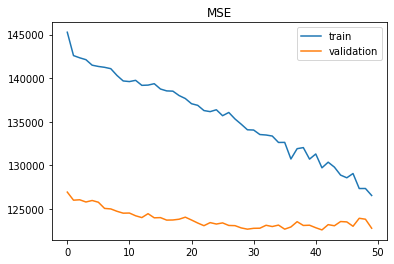

wMAE - train: 62.61, test: 68.5. Current rank: 4 
mae  - train: 125.54, test: 134.93
mse  - train: 119278.06, test: 146644.31
r2   - train: 0.13, test: 0.03
Elapsed: 2905 seconds.


In [93]:
models.time() # measuring total time

callbacks = [keras.collbacks.EarlyStopping(patience=3, restore_best_weights=True),
             keras.collbacks.CSVLogger('training_cnn5.log')]

cnn_history = cnn5.fit(
    x = W_train, 
    y = y_train,
    epochs = 50, 
    validation_split = 0.2,
    batch_size = 128, 
    #callbacks = callbacks, # no early stopping in this model; add it in consequent models
    verbose=2)


keras.models.save_model(
    cnn5, filepath='cnn_5', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['train', 'validation'], loc='best')
plt.title('MSE')
plt.show()

models.add(
    name = 'cnn_5',
    model = None, # storing model externally, see https://stackoverflow.com/a/52691785/12451060
    pred_train = cnn5.predict(W_train),
    pred_test = cnn5.predict(W_test)
)

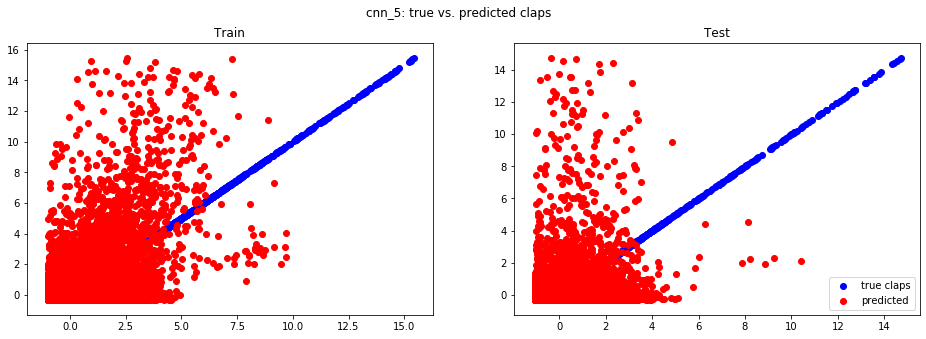

In [94]:
models.visualize('cnn_5', zscores=True)

Despite a relatively good wMAE, it does not seem that this model was able to learn many patterns in data. Overfitting may be a potential problem here, so that early stopping will be implemented for the next models. 

One other interesting enhancement is to add numeric features as additional inputs to the model. We will do this in the consequent models.

## 6. Mixed input model

Luckily, Keras allows for a very flexible design of a neural network, and it is almost trivial to design a mixed input model. The following model accepts vectorized text, which is then passed through a CNN with 20 filters of sizes 1 to 4, after which it is concatenated and max pooled. Numeric features pass a dense layer with 10 filters, after which they are concatenated with the outputs of the CNN part of the model, followed by a droupout layer to reduce overfitting, another dense layer with 10 filters, and another droupout layer. The model is concluded with a final dense layer with 1 filter and a linear activation.

For this and the consequent models, an early stopping is enforced if for more than two epochs the validation loss (as measured by the MSE) is not decreasing.

![mixed1](https://drive.google.com/uc?export=view&id=1rBYXzQFrCJVUIXUJM7EMekpP4bryCLYs)

_(Numbers in grey indicate the output dimensions of each layer)_

In [382]:
# simply defining two inputs and eventually concatenating them
# nice

import keras
from keras import layers

# model partially follows Zhang & Wallace 2015
# https://cloud.githubusercontent.com/assets/11842615/25828679/df9dc5c6-3451-11e7-9792-c8fa32dd920f.png

n_filters_conv = 5
n_filters_dense = 10
droupout_rate = 0.5


# convolutional part with varying filters:
conv_input = keras.Input(shape=(100, 300), name="doc")
conv_layer = []

for filter_size in (1, 2, 3, 4):
    c = layers.Conv1D(n_filters_conv, filter_size, 
                      padding='same', 
                      activation='relu', 
                      name=f'conv_{filter_size}_{n_filters_conv}')(conv_input)
    conv_layer.append(c)

# concatenate:
c = layers.Concatenate(name=f'concatenate_to_100x{n_filters_conv*4}')(conv_layer)
c = layers.GlobalMaxPooling1D(name=f'max_pool_to_{n_filters_conv*4}')(c)

# add numeric part:
num_input = keras.Input(shape=(len(NUMVARS)), name="num_features")
d = layers.Dense(n_filters_dense, activation='relu', name=f'num_to_{n_filters_dense}')(num_input)
c = layers.Concatenate(name='conv_plus_num')([c, d])

# dense layers:
c = layers.Dropout(droupout_rate, name='dropout')(c)
c = layers.Dense(n_filters_dense, activation='relu', name=f'dense_to_{n_filters_dense}')(c)
c = layers.Dropout(droupout_rate, name='dropout2')(c)
c = layers.Dense(1, activation='linear', name='dense_to_1')(c)

# build model:
mixed = keras.Model([conv_input, num_input], c, name='mixed1')
mixed.compile(loss='mean_squared_error')


mixed.summary()
#keras.utils.plot_model(mixed, show_shapes=False)

Model: "mixed1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
doc (InputLayer)                [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv_1_5 (Conv1D)               (None, 100, 5)       1505        doc[0][0]                        
__________________________________________________________________________________________________
conv_2_5 (Conv1D)               (None, 100, 5)       3005        doc[0][0]                        
__________________________________________________________________________________________________
conv_3_5 (Conv1D)               (None, 100, 5)       4505        doc[0][0]                        
_____________________________________________________________________________________________

Epoch 00028: early stopping
INFO:tensorflow:Assets written to: mixed/assets


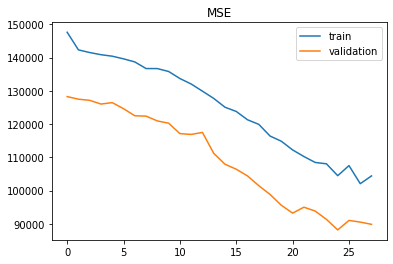

wMAE - train: 21.52, test: 21.98. Current rank: 2 
mae  - train: 92.49, test: 93.81
mse  - train: 95611.39, test: 107177.45
r2   - train: 0.3, test: 0.29
Elapsed: 1646 seconds.


In [154]:
models.time() # measuring total time

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, verbose=2),
             keras.callbacks.CSVLogger(DIR + 'training_mixed.log')]

cnn_history = mixed.fit(
    x = [W_train, X_train[list(NUMVARS)]], 
    y = y_train,
    epochs = 50, 
    validation_split = 0.2,
    batch_size = 128, 
    callbacks = callbacks, 
    verbose=0)


keras.models.save_model(
    mixed, filepath=DIR + 'mixed', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['train', 'validation'], loc='best')
plt.title('MSE')
plt.show()


models.add(
    name = 'mixed',
    model = None, # storing model externally, see https://stackoverflow.com/a/52691785/12451060
    pred_train = nonnegative(mixed.predict([W_train, X_train[list(NUMVARS)]])),
    pred_test = nonnegative(mixed.predict([W_test, X_test[list(NUMVARS)]]))
)

mixed - train: 3 .. 53 .. 1011
mixed - test: 4 .. 53 .. 965


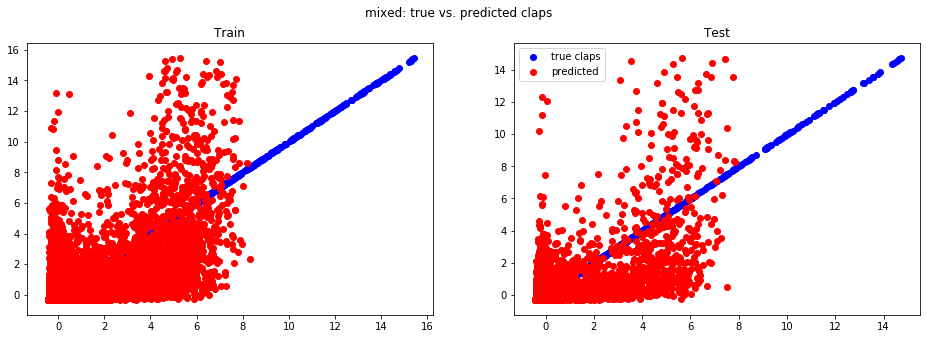

In [162]:
models.visualize('mixed', zscores=True)
models.distr('mixed')

This is far from a perfect result but it is quite good! Seems like this model can learn something about our data and decrease our wMAE further (despite a somewhat lower R2 statistic). Can we change the architecture of the neural network to improve the fit?

## 7. Mixed input 2

The main difference of this model to the previous one is that it does not allow for a straight-forward dropout from the CNN part of the model but fully preserves its output until the dense layer. Will it perform better?

![mixed2](https://drive.google.com/uc?export=view&id=1GLeAlGs0CsRQfAZlTF5EpG5_56E4uWxx)

_(Numbers in grey indicate the output dimensions of each layer)_

In [383]:
# simply defining two inputs and eventually concatenating them
# nice

import keras
from keras import layers

# model partially follows Zhang & Wallace 2015
# https://cloud.githubusercontent.com/assets/11842615/25828679/df9dc5c6-3451-11e7-9792-c8fa32dd920f.png

n_filters_conv = 5
n_filters_dense = 10
droupout_rate = 0.5


# convolutional part with varying filters:
conv_input = keras.Input(shape=(100, 300), name="doc")
conv_layer = []

for filter_size in (1, 2, 3, 4):
    c = layers.Conv1D(n_filters_conv, filter_size, 
                      padding='same', 
                      activation='relu', 
                      name=f'conv_{filter_size}_{n_filters_conv}')(conv_input)
    conv_layer.append(c)

# concatenate:
c = layers.Concatenate(name=f'concatenate_to_100x{n_filters_conv*4}')(conv_layer)
c = layers.GlobalMaxPooling1D(name=f'max_pool_to_{n_filters_conv*4}')(c)

# add numeric part:
num_input = keras.Input(shape=(len(NUMVARS)), name="num_features")
d = layers.Dense(n_filters_dense, activation='relu', name=f'num_to_{n_filters_dense}')(num_input)
d = layers.Dropout(droupout_rate, name='dropout')(d)

c = layers.Concatenate(name='conv_plus_num')([c, d])

# dense layers:
c = layers.Dense(n_filters_dense, activation='relu', name=f'dense_to_{n_filters_dense}')(c)
c = layers.Dropout(droupout_rate, name='dropout2')(c)
c = layers.Dense(1, activation='linear', name='dense_to_1')(c)


# build model:
mixed2 = keras.Model([conv_input, num_input], c, name='mixed1')
mixed2.compile(loss='mean_squared_error')


mixed2.summary()
#keras.utils.plot_model(mixed2, show_shapes=False)

Model: "mixed1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
doc (InputLayer)                [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv_1_5 (Conv1D)               (None, 100, 5)       1505        doc[0][0]                        
__________________________________________________________________________________________________
conv_2_5 (Conv1D)               (None, 100, 5)       3005        doc[0][0]                        
__________________________________________________________________________________________________
conv_3_5 (Conv1D)               (None, 100, 5)       4505        doc[0][0]                        
_____________________________________________________________________________________________

Epoch 00042: early stopping
INFO:tensorflow:Assets written to: mixed2b/assets


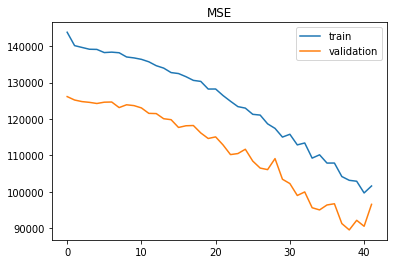

wMAE - train: 26.51, test: 27.08. Current rank: 6 
mae  - train: 96.24, test: 99.45
mse  - train: 96803.35, test: 114573.65
r2   - train: 0.29, test: 0.24
Elapsed: 2727 seconds.


In [271]:
models.time() # measuring total time

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, verbose=2),
             keras.callbacks.CSVLogger(DIR + 'training_mixed2.log')]

cnn_history = mixed2.fit(
    x = [W_train, X_train[list(NUMVARS)]], 
    y = y_train,
    epochs = 50, 
    validation_split = 0.2,
    batch_size = 128, 
    callbacks = callbacks, 
    verbose=0)


keras.models.save_model(
    mixed2, filepath=DIR + 'mixed2b', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['train', 'validation'], loc='best')
plt.title('MSE')
plt.show()


models.add(
    name = 'mixed2',
    model = None, # storing model externally, see https://stackoverflow.com/a/52691785/12451060
    pred_train = nonnegative(mixed2.predict([W_train, X_train[list(NUMVARS)]])),
    pred_test = nonnegative(mixed2.predict([W_test, X_test[list(NUMVARS)]]))
)

mixed - train: 3 .. 53 .. 1011
mixed - test: 4 .. 53 .. 965


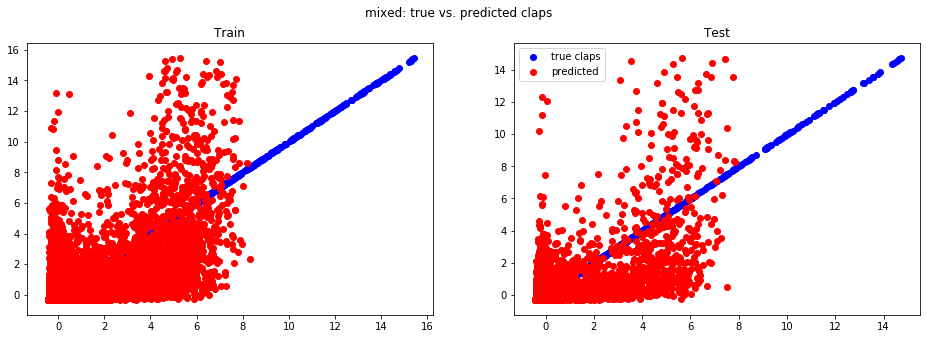

In [163]:
models.visualize('mixed', zscores=True)
models.distr('mixed')

No, a better fit could not be achieved.

## 8. Mixed inputs - tune parameters

When designing a neural network, two considerations appear important:

* What architecture of the neural network should be chosen? (Which layers should it incorporate in which order?)
* What hyperparameter should be chosen within the chosen architecture?

While the former question is usually fully left to the judgement of a data scientist, the answer to the latter question can be optimized with respect to the given data and the selected architecture. 

Assuming that the first design of the mixed input model is better than the one of the second, what would be the best choice of hyperparameters (number of convolutional and dense filters and the dropout rate) with respect to the validation MAE? 

Parameter tuning will be performed with the help of the **kerastuner** package, which will randomly select 20 combinations of hyperparameter values from a pre-defined grid:

* number of convolutional filters: 3 to 6 with a step of 1,
* number of dense filters: 5 to 15 with a step of 1,
* dropout rate: 0.4 (rather very restrictive) to 0.7 with a step of 0.05.

In [ ]:
import keras
from keras import layers
from kerastuner import RandomSearch

# model partially follows Zhang & Wallace 2015
# https://cloud.githubusercontent.com/assets/11842615/25828679/df9dc5c6-3451-11e7-9792-c8fa32dd920f.png
# https://keras-team.github.io/keras-tuner/#usage-the-basics


def build_model(hp):
    
    # tunable hyperparameters:
    #n_filters_conv = hp.Int('n_filters_conv', 3, 6, step=1) # > 4
    #n_filters_dense = hp.Int('n_filters_dense', 5, 15, step=1) # > 7
    #dropout_rate = hp.Float('dropout_rate', 0.4, 0.7, step=0.05) # > 0.35


    # convolutional part with varying filters:
    conv_input = keras.Input(shape=(100, 300), name="doc")
    conv_layer = []

    for filter_size in (1, 2, 3, 4):
        c = layers.Conv1D(hp.Int('n_filters_conv', 3, 6, step=1), filter_size, 
                          padding='same', 
                          activation='relu', 
                          name=f'conv_{filter_size}_n_filters_conv')(conv_input)
        conv_layer.append(c)

    # concatenate:
    c = layers.Concatenate(name=f'concatenate_to_100xn_filters_conv3')(conv_layer)
    c = layers.GlobalMaxPooling1D(name=f'max_pool_to_n_filters_conv3')(c)

    # add numeric part:
    num_input = keras.Input(shape=(len(NUMVARS)), name="num_features")
    d = layers.Dense(hp.Int('n_filters_dense', 5, 15, step=1),
                     activation='relu', name=f'num_to_n_filters_dense')(num_input)
    c = layers.Concatenate(name='conv_plus_num')([c, d])

    # dense layers:
    c = layers.Dropout(hp.Float('dropout_rate', 0.4, 0.7, step=0.05), name='dropout')(c)
    c = layers.Dense(hp.Int('n_filters_dense', 5, 15, step=1), activation='relu', 
                     name=f'dense_to_n_filters_dense')(c)
    c = layers.Dropout(hp.Float('dropout_rate', 0.4, 0.7, step=0.05), name='dropout2')(c)
    c = layers.Dense(1, activation='linear', name='dense_to_1')(c)

    # build model:
    mixed = keras.Model([conv_input, num_input], c, name='mixed1')
    mixed.compile(loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return mixed


callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, verbose=2)]

tuner = RandomSearch(
    build_model,
    objective = 'val_mean_absolute_error',
    max_trials = 20,
    executions_per_trial = 1,
    directory = DIR,
    project_name = 'mixed_TUNING')


tuner.search(x = [W_train, X_train[list(NUMVARS)]],
             y = y_train,
             epochs = 30,
             callbacks = callbacks,
             validation_split = 0.2,
             verbose = 2
            )

In [173]:
tuner.results_summary(1) # best parameters

In [384]:
import keras
from keras import layers

# using the optimized hyperparameters:
n_filters_conv = 3
n_filters_dense = 11
droupout_rate = 0.45


# convolutional part with varying filters:
conv_input = keras.Input(shape=(100, 300), name="doc")
conv_layer = []

for filter_size in (1, 2, 3, 4):
    c = layers.Conv1D(n_filters_conv, filter_size, 
                      padding='same', 
                      activation='relu', 
                      name=f'conv_{filter_size}_{n_filters_conv}')(conv_input)
    conv_layer.append(c)

# concatenate:
c = layers.Concatenate(name=f'concatenate_to_100x{n_filters_conv*4}')(conv_layer)
c = layers.GlobalMaxPooling1D(name=f'max_pool_to_{n_filters_conv*4}')(c)

# add numeric part:
num_input = keras.Input(shape=(len(NUMVARS)), name="num_features")
d = layers.Dense(n_filters_dense, activation='relu', name=f'num_to_{n_filters_dense}')(num_input)
c = layers.Concatenate(name='conv_plus_num')([c, d])

# dense layers:
c = layers.Dropout(droupout_rate, name='dropout')(c)
c = layers.Dense(n_filters_dense, activation='relu', name=f'dense_to_{n_filters_dense}')(c)
c = layers.Dropout(droupout_rate, name='dropout2')(c)
c = layers.Dense(1, activation='linear', name='dense_to_1')(c)

# build model:
mixed3 = keras.Model([conv_input, num_input], c, name='mixed1f')
mixed3.compile(loss='mean_squared_error')

if IN_COLAB: 
    keras.utils.plot_model(mixed3, show_shapes=False)
else:
    mixed3.summary()

Model: "mixed1f"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
doc (InputLayer)                [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
conv_1_3 (Conv1D)               (None, 100, 3)       903         doc[0][0]                        
__________________________________________________________________________________________________
conv_2_3 (Conv1D)               (None, 100, 3)       1803        doc[0][0]                        
__________________________________________________________________________________________________
conv_3_3 (Conv1D)               (None, 100, 3)       2703        doc[0][0]                        
____________________________________________________________________________________________

Epoch 00031: early stopping
INFO:tensorflow:Assets written to: mixed3/assets


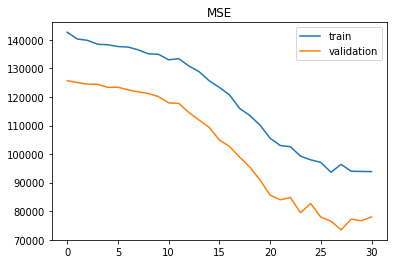

wMAE - train: 30.84, test: 31.3. Current rank: 5 
mae  - train: 93.6, test: 95.68
mse  - train: 81840.35, test: 92825.07
r2   - train: 0.4, test: 0.38
Elapsed: 1683 seconds.


In [174]:
models.time() # measuring total time

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, verbose=2),
             keras.callbacks.CSVLogger(DIR + 'training_mixed3.log')]

cnn_history = mixed3.fit(
    x = [W_train, X_train[list(NUMVARS)]], 
    y = y_train,
    epochs = 50, 
    validation_split = 0.2,
    batch_size = 128, 
    callbacks = callbacks, 
    verbose=0)


keras.models.save_model(
    mixed3, filepath=DIR + 'mixed3', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.legend(['train', 'validation'], loc='best')
plt.title('MSE')
plt.show()


models.add(
    name = 'mixed3',
    model = None, # storing model externally, see https://stackoverflow.com/a/52691785/12451060
    pred_train = nonnegative(mixed3.predict([W_train, X_train[list(NUMVARS)]])),
    pred_test = nonnegative(mixed3.predict([W_test, X_test[list(NUMVARS)]]))
)

Interestingly enough, the model with optimized hyperparameters performs worse than the original model. This can have the following explanation: The fine-tuning was defined such that only one execution per choice of hyperparameters was tried. This single execution with randomly initiated weights may be not generalizable. 

A possible improvement would therefore be to allow for more trials per execution. Moreover, some further potential improvements at the level of the model architecture remain partially uninvestigated, as it would require many more trials to arrive at the "perfect" model. Within the boundaries of this assignment, the first mixed input model can be assumed to be the best model to solve the given task.

----

# ENSEMBLE & final prediction

## Model evaluation

The following overview (see `models.summary()` below) compares all models built in the previous section. 

Interestingly, if we would only evaluate models based on the wMAE, the best choice would be the **train_median** model, predicting all claps equal to 6. Obviously, this model does not offer much explanation to the actual distribution of claps, which is also mirrored in a negative R2 statistic value as well as comparably high MAE and MSE.

The first **mixed** input model scores second based on the wMAE. It also appears to have some grasp on the data structure, having the lowest test MAE among all other models: on average, each prediction is 94 claps off its true value. Obviously, this still is a very high error, which may not be satisfactory for a business deployment. 

The **no_text** linear regression and **lasso_all** regression have very close results, suggesting that the bag of words used in the **lasso_all** model does not improve model performance. These two models have a relatively high (for the current task) R2 value, with only the random forest **rf_all** solution scoring slightly better. At the same time, the random forest has likely overfitted the train data, and it has a much higher wMAE than the regressive models.

**cnn5**, which has only seen the textual embeddings, sadly scores last on all evaluation criteria. It does, however, overperform the benchmark **train_mean**.

In [381]:
print('Correlation between no_text and lasso_all prediction (for train): ' +
      str(np.corrcoef(models.predictions['no_text']['train'], models.predictions['lasso_all']['train'])[1,0]))

Correlation between no_text and lasso_all prediction (for train): 0.99998003233627


In [360]:
#models = Models()
#models.load(DIR + 'MODELS_30aug.pkl')
models.summary()

train_median:
wMAE - train: 6.49, test: 6.47. Current rank: 1 
mae  - train: 109.66, test: 110.41
mse  - train: 147736.1, test: 161819.38
r2   - train: -0.08, test: -0.07

mixed:
wMAE - train: 21.52, test: 21.98. Current rank: 2 
mae  - train: 92.49, test: 93.81
mse  - train: 95611.39, test: 107177.45
r2   - train: 0.3, test: 0.29

no_text:
wMAE - train: 26.9, test: 26.77. Current rank: 3 
mae  - train: 105.43, test: 105.33
mse  - train: 82177.71, test: 89891.34
r2   - train: 0.4, test: 0.4

lasso_all:
wMAE - train: 27.07, test: 26.93. Current rank: 4 
mae  - train: 105.3, test: 105.19
mse  - train: 82191.68, test: 89917.98
r2   - train: 0.4, test: 0.4

mixed2:
wMAE - train: 26.51, test: 27.08. Current rank: 5 
mae  - train: 96.24, test: 99.45
mse  - train: 96803.35, test: 114573.65
r2   - train: 0.29, test: 0.24

mixed3:
wMAE - train: 30.84, test: 31.3. Current rank: 6 
mae  - train: 93.6, test: 95.68
mse  - train: 81840.35, test: 92825.07
r2   - train: 0.4, test: 0.38

rf_all:
wMAE -

Often, using heterogenous model ensembles can help boosting the accuracy of prediction results. The first __mixed__ input model and one of the regressions seem to be good choices for this purpose, with the mixed model having lower wMAE and MAE, and regressions having a better R2 statistic. 

Despite the fact that __no_text__ and __lasso_all__ deliver very similar results, I believe that lasso regression, having seen the tokenized texts, _may know more_ about the data. Hence, it will be used as a second model in the ensemble. The six numeric features will be repeatedly added to the ensemble. In other words, such an ensemble design can be seen as a regular model which, however, has access to predictions generated by two other models, which should improve overall prediction results.

Three alternatives will be examined: an ensemble with a head consisting of a dense layer with 5 filters, a dropout layer, and a dense layer with linear activation; an ensemble with a linear regression head; and a linear ensemble which accepts features of the last dense layer of the mixed model rather than the final result. For a better understanding, detailed diagrams are provided for each ensemble.

## Ensemble with dense layers

![ensemble1](https://drive.google.com/uc?export=view&id=1iLTXpDx8AOXDywTcfGJ0jP_IY4gamZQL)

In [188]:
import keras
from keras import layers

n_filters_dense = 5
droupout_rate = 0.5

# inputs:
num_input = keras.Input(shape=(len(NUMVARS)), name="num_features")
lasso_input = keras.Input(shape=(1), name="lasso_output")
mixed_input = keras.Input(shape=(1), name="mixed_output")

# concatenate:
c = layers.Concatenate(name='concatenate_inputs')([num_input, lasso_input, mixed_input])

# dense part:
c = layers.Dense(n_filters_dense, activation='relu', name=f'dense_to_{n_filters_dense}')(c)
c = layers.Dropout(droupout_rate, name='dropout')(c)
c = layers.Dense(1, activation='linear', name='dense_to_1')(c)

# build model:
ensemble = keras.Model([num_input, lasso_input, mixed_input], c, name='ensemble')
ensemble.compile(loss='mean_squared_error')

if IN_COLAB: 
    keras.utils.plot_model(ensemble, show_shapes=False)
else:
    ensemble.summary()

Model: "ensemble"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num_features (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
lasso_output (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
mixed_output (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_inputs (Concatenate (None, 8)            0           num_features[0][0]               
                                                                 lasso_output[0][0]        

Epoch 00012: early stopping
INFO:tensorflow:Assets written to: ensemble/assets


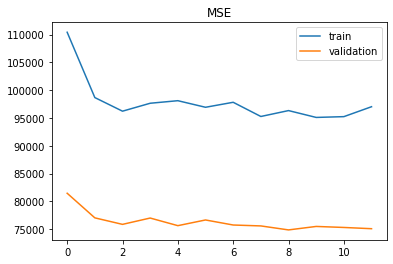

wMAE - train: 18.38, test: 18.56. Current rank: 2 
mae  - train: 89.63, test: 91.04
mse  - train: 80463.72, test: 89924.67
r2   - train: 0.41, test: 0.4
Elapsed: 7 seconds.


In [189]:
models.time() # measuring total time

callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, verbose=2),
             keras.callbacks.CSVLogger(DIR + 'training_ensemble.log')]

ens_history = ensemble.fit(
    x = [X_train[list(NUMVARS)], 
         models.predictions['lasso_all']['train'],
         models.predictions['mixed']['train']], 
    y = y_train,
    epochs = 50, 
    validation_split = 0.2,
    batch_size = 128, 
    callbacks = callbacks, 
    verbose=0)


keras.models.save_model(
    ensemble, filepath=DIR + 'ensemble', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None)

plt.plot(ens_history.history['loss'])
plt.plot(ens_history.history['val_loss'])
plt.legend(['train', 'validation'], loc='best')
plt.title('MSE')
plt.show()


models.add(
    name = 'ensemble',
    model = None, # storing model externally, see https://stackoverflow.com/a/52691785/12451060
    pred_train = nonnegative(ensemble.predict([
        X_train[list(NUMVARS)], 
        models.predictions['lasso_all']['train'],
        models.predictions['mixed']['train'] ])),
    pred_test = nonnegative(ensemble.predict([
        X_test[list(NUMVARS)], 
        models.predictions['lasso_all']['test'],
        models.predictions['mixed']['test'] ]))
)

ensemble - train: 2 .. 73 .. 1368
ensemble - test: 2 .. 73 .. 1326


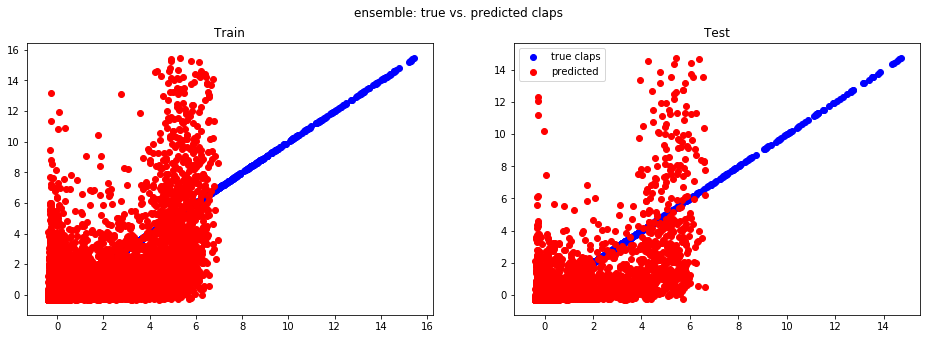

In [190]:
models.distr('ensemble')
models.visualize('ensemble', zscores=True)

This is a clear success! Despite the model still not being able to predict claps with high values, this ensemble reaches an even smaller wMAE and MAE than all preceding models (MAE: an improve of 3 claps compared to __mixed__ model). At the same time, it preserves the higher R2 from the Lasso model.

## Linear ensemble

Same as before but with a linear head without any additional dense and dropout layers.

![ensemble2](https://drive.google.com/uc?export=view&id=1JWujtWkCXCCytfam-wV4NmwZvHdRQh57)

In [227]:
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression

#normalizer = Normalizer() # unexpectedly, all metrics are worse when normalizing
reg = LinearRegression()

#lin_ens = Pipeline([('normalizer', normalizer), ('regressor', reg)])
lin_ens = reg

ens_input_train = X_train[list(NUMVARS)].copy()
ens_input_train['lasso'] = models.predictions['lasso_all']['train']
ens_input_train['mixed'] = models.predictions['mixed']['train']

ens_input_test = X_test[list(NUMVARS)].copy()
ens_input_test['lasso'] = models.predictions['lasso_all']['test']
ens_input_test['mixed'] = models.predictions['mixed']['test']


models.time()
models.add(
    name = 'lin_ensemble',
    model = lin_ens.fit(ens_input_train, y_train),
    pred_train = nonnegative(lin_ens.predict(ens_input_train)),
    pred_test = nonnegative(lin_ens.predict(ens_input_test))
)

wMAE - train: 37.68, test: 38.32. Current rank: 10 
mae  - train: 101.29, test: 104.13
mse  - train: 73702.54, test: 82835.16
r2   - train: 0.46, test: 0.45
Elapsed: 0 seconds.


lin_ensemble - train: 0 .. 110 .. 2146
lin_ensemble - test: 0 .. 111 .. 2057


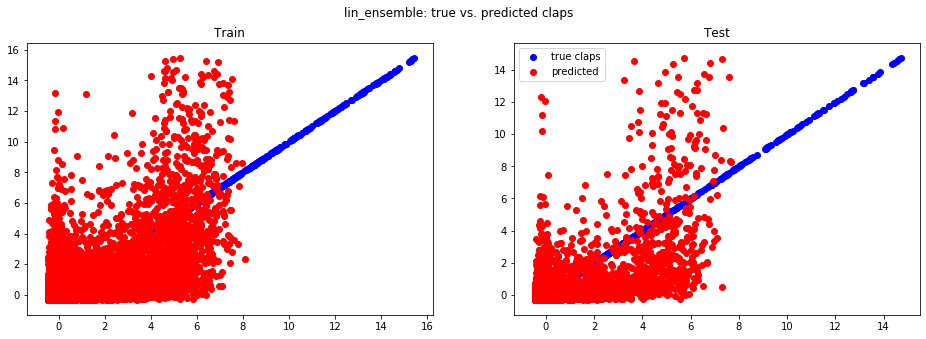

In [229]:
models.distr('lin_ensemble')
models.visualize('lin_ensemble', zscores=True)

This ensemble has a much higher test MAE (104 vs. 91 for the previous ensemble), which is likely due to the fact that this model predicts a higher range of claps, going beyond 2000 predicted claps (previous ensemble: maximum is around 1350 claps). Furthermore, this linear ensemble has the highest R2 and the lowest MSE among all models. 

## Linear ensemble with raw values from CNN

The idea behind this ensemble architecture is the intuition that the penultimate layer of the mixed NLP model represents a set of 10 latent features that carry some valuable information for the final prediction. By concatenating them with the results of another model and with the numeric features, we obtain a more informed model compared to the previous two ensembles.

![ensemble3](https://drive.google.com/uc?export=view&id=15cH88OXKs5-eQlLUJwAHb_tkekP3J-ow)

In [388]:
import keras
from keras import layers

# load mixed model and make an extract/a submodel without the last dropout and dense layers:
mixed_cnn = keras.models.load_model(DIR + 'mixed')
mixed_extract = keras.Model(mixed_cnn.input, mixed_cnn.get_layer('dense_to_10').output)
#mixed_extract.summary()

# make predictions and take a look at them:
extract_train = mixed_extract.predict([W_train, X_train[list(NUMVARS)]])
extract_test = mixed_extract.predict([W_test, X_test[list(NUMVARS)]])

extract_train = pd.DataFrame(extract_train)
extract_test = pd.DataFrame(extract_test)

extract_train.describe() # latent features

,0,1,2,3,4,5,6,7,8,9
count,49605,49605,49605,49605,49605,49605,49605,49605,49605,49605
mean,0,0,0,3,0,4,4,0,4,15
std,0,0,0,4,0,17,16,2,17,21
min,0,0,0,0,0,0,0,0,0,0
25%,0,0,0,0,0,0,0,0,0,4
50%,0,0,0,2,0,0,0,0,0,9
75%,0,0,0,6,0,0,0,0,0,16
max,9,5,7,32,3,148,143,45,146,168


In [395]:
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression

lin_ens_ext = LinearRegression()

ens3_input_train = X_train[list(NUMVARS)].copy()
ens3_input_train.reset_index(inplace=True, drop=True)
ens3_input_train['lasso'] = models.predictions['lasso_all']['train']
ens3_input_train[extract_train.columns] = extract_train

ens3_input_test = X_test[list(NUMVARS)].copy()
ens3_input_test.reset_index(inplace=True, drop=True)
ens3_input_test['lasso'] = models.predictions['lasso_all']['test']
ens3_input_test[extract_test.columns] = extract_test


models.add(
    name = 'lin_ensemble_extended',
    model = lin_ens_ext.fit(ens3_input_train, y_train),
    pred_train = nonnegative(lin_ens_ext.predict(ens3_input_train)),
    pred_test = nonnegative(lin_ens_ext.predict(ens3_input_test))
)

wMAE - train: 38.11, test: 38.61. Current rank: 10 
mae  - train: 101.35, test: 104.04
mse  - train: 73483.55, test: 82388.73
r2   - train: 0.46, test: 0.45


lin_ensemble_extended - train: 0 .. 111 .. 2167
lin_ensemble_extended - test: 0 .. 112 .. 2082


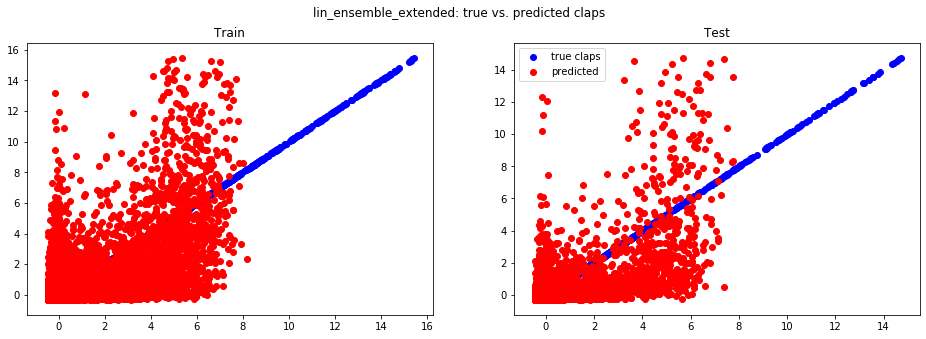

In [390]:
models.distr('lin_ensemble_extended')
models.visualize('lin_ensemble_extended', zscores=True)

This model has an even better MSE! The MAE, however, remains at a relatively high level. 

## Ensemble selection

Clearly, each ensemble improves the result in a certain way. The first ensemble (with dense layers) is successful at minimizing the wMAE, which we have previously defined as a main performance evaluation metric, having a potential business application in mind. Yet it is incapable of predicting claps values higher than around 1300 (which may also at least partially explain the lower wMAE).

The second and third ensembles (linear and linear extended) deliver the minimal MSE among all of the examined models, and their prediction ranges reach further up to ca. 2100 claps.

To make a more informed decision between the two ensembles, we can have a look at how well the distribution of each of the predictions matches the true distribution (see histograms below). Clearly, the first ensemble is closer to the true distribution of claps. 

Given the available evidence, it can be concluded that it is the best model. It will be therefore used to predict the claps received by the articles contained in the `Test.csv` dataset.

In [410]:
for m in ['ensemble', 'lin_ensemble', 'lin_ensemble_extended']:
    models.distr(m)
    models.print_stats(m)
    print()

ensemble - train: 2 .. 73 .. 1368
ensemble - test: 2 .. 73 .. 1326
wMAE - train: 18.38, test: 18.56. Current rank: 2 
mae  - train: 89.63, test: 91.04
mse  - train: 80463.72, test: 89924.67
r2   - train: 0.41, test: 0.4

lin_ensemble - train: 0 .. 111 .. 2147
lin_ensemble - test: 0 .. 111 .. 2057
wMAE - train: 38.0, test: 38.6. Current rank: 9 
mae  - train: 101.46, test: 104.3
mse  - train: 73651.71, test: 82807.85
r2   - train: 0.46, test: 0.45

lin_ensemble_extended - train: 0 .. 111 .. 2167
lin_ensemble_extended - test: 0 .. 112 .. 2082
wMAE - train: 38.11, test: 38.61. Current rank: 10 
mae  - train: 101.35, test: 104.04
mse  - train: 73483.55, test: 82388.73
r2   - train: 0.46, test: 0.45



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x187f726a0>]],
      dtype=object)

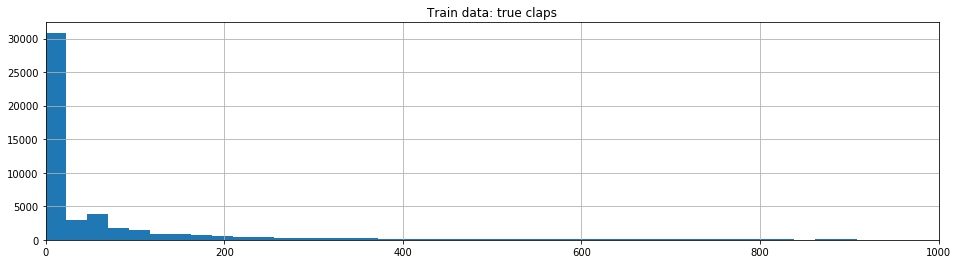

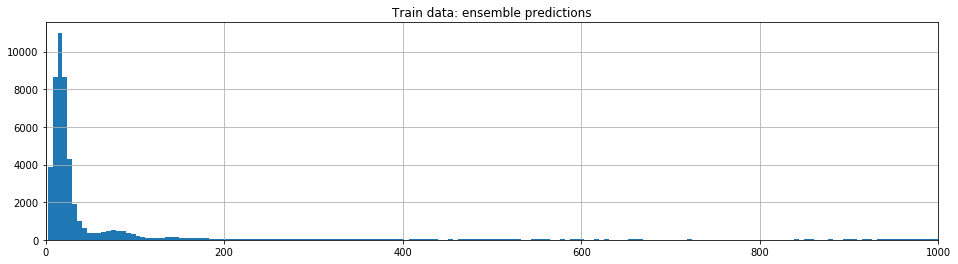

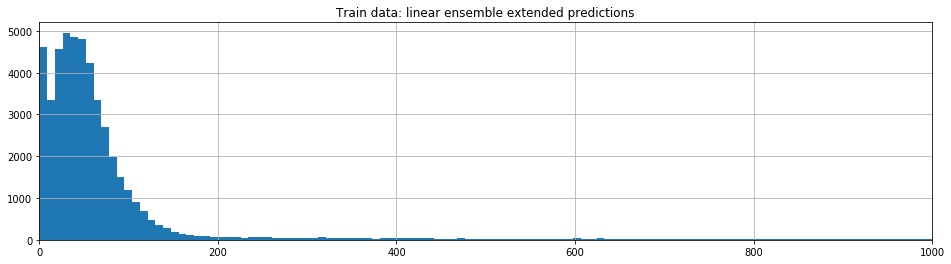

In [436]:
def hist(var, name, bins=250):
    x = pd.DataFrame(var)
    x.columns = [name]
    p = x.hist(bins=bins, figsize=(16, 4))
    p[0][0].set_xlim((0, 1000))
    return p

hist(y_train, 'Train data: true claps')
hist(models.predictions['ensemble']['train'], 'Train data: ensemble predictions')
hist(models.predictions['lin_ensemble_extended']['train'], 'Train data: linear ensemble extended predictions')

## Final prediction for the assignment

In this final part, the pre-prepared test data is loaded and outliers are replaced according to the upper bounds of the `X_train` dataset (which was used to train all models). Prediction is then being made using the ensemble incorporating results of the Lasso regression and of the Mixed input model.

In [330]:
replacer = ReplaceOutliers()

# reuse upper bounds from the X_train dataset:
with open(DIR + 'replacer_ub.pkl', 'rb') as f:
    replacer.ub = pickle.load(f)
    
with open(DIR + 'ready_for_analysis.pkl', 'rb') as f:
    train_target3, train3, test3, word_vectors = pickle.load(f)
print('Loaded from local storage.')


# data to use for predictions:
testdata = replacer.transform(test3)
testvectors = word_vectors['test']

Loaded from local storage.
SincePublished: 209 values replaced with the upper bound of 396
Responses: 200 values replaced with the upper bound of 6
Images: 3 values replaced with the upper bound of 12
Links: 2 values replaced with the upper bound of 25
Length: 67 values replaced with the upper bound of 13059
Words: 0 values replaced with the upper bound of 538
Readability: 0 values replaced with the upper bound of 66


In [348]:
# load models:
mixed_cnn = keras.models.load_model(DIR + 'mixed')
ensemble = keras.models.load_model(DIR + 'ensemble')


# make prediction(s):
mixed_prediction = nonnegative(mixed_cnn.predict([testvectors, testdata[list(NUMVARS)]]))
lasso_prediction = nonnegative(models.models['lasso_all'].predict(testdata))

ensemble_prediction = nonnegative(ensemble.predict([
    testdata[list(NUMVARS)], 
    lasso_prediction, 
    mixed_prediction]))


# match the suggested output format and write csv-file:
final_prediction = pd.DataFrame(ensemble_prediction)
final_prediction.columns = ['Claps']
final_prediction.reset_index(inplace=True)
final_prediction.to_csv('Submission_Gleb_Zhidkov.csv', index=False)


# descriptive stats:
final_prediction.describe()

,Claps
count,514
mean,429
std,334
min,0
25%,72
50%,430
75%,752
max,1108


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x188b395e0>]],
      dtype=object)

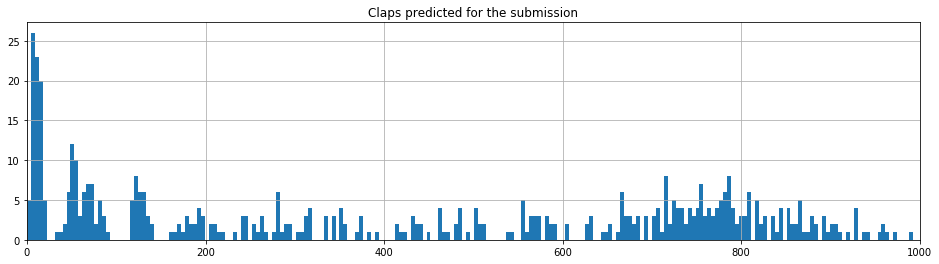

In [446]:
hist(final_prediction.Claps, 'Claps predicted for the submission') 
# looks pretty much like a city with skyscrapers

# Appendix: Transformers

Before making some success with CNN/Mixed input models, I have attempted to build a model using BERT. Unfortunately, the pre-prepared regression model from the **bert-sklearn** package learned a loss-optimizing pattern that had nothing to do with the actual distribution of data (all predictions in a small range around 55 claps). Due to the time constraint, I did not further work with transformers; however, I believe that they _may_ allow for an even better prediction accuracy. The code for the BERT model is presented in this appendix.

----

BERT requires some extra data preparation steps:

*   Using (cleaned) text, keeping sentence structure which is of interest to BERT
*   Running on Colab to make use of extra GPU
*   Removing everything not needed from RAM to avoid notebook from crashing
*   Using **bert-sklearn** as a very intuitive and powerful **torch** wrapper for BERT
*   Removing almost-empty data entries when training, because they cause an internal error at the level of **torch** (non-matching dimensions between input and target)

In [9]:
# free up RAM:

X_train = X_train[['Text']]
X_test = X_test[['Text']]

del W_train, W_test 

In [16]:
try:
    from bert_sklearn import BertClassifier
except:
    print('Installing bert_sklearn from github...')
    !git clone -b master https://github.com/charles9n/bert-sklearn
    !cd bert-sklearn; pip install .

# demo:
# https://colab.research.google.com/drive/1-wTNA-qYmOBdSYG7sRhIdOrxcgPpcl6L#scrollTo=VQW8xgpSlIKG

from bert_sklearn import BertRegressor
from bert_sklearn import load_model

In [17]:
import torch
print('pytorch version:', torch.__version__)

try:
    print('GPU:',torch.cuda.get_device_name(0))
except Exception as e:
    print(f'WARNING: No GPU identified and/or this error: {e}')

pytorch version: 1.6.0


In [19]:
#https://github.com/charles9n/bert-sklearn/blob/master/Options.md

bert = BertRegressor(bert_model = 'bert-base-uncased',
                    max_seq_length = 256, #100, # 512 tokens is max
                    validation_fraction = 0.2,
                    epochs = 3,
                    train_batch_size = 16,
                    logfile = DIR+'bert_sklearn.log')

Building sklearn text regressor...


In [18]:
#bert_train = np.array(words_to_docs(X_train['Text'], drop_dots=False))
#bert_test = np.array(words_to_docs(X_test['Text'], drop_dots=False))

bert_train = words_to_docs(X_train['Text'], drop_dots=False)
bert_test = words_to_docs(X_test['Text'], drop_dots=False)


KEEP = [idx for idx, x in enumerate(bert_train) if len(x) > 100]
bert_train2 = [bert_train[i] for i in KEEP]
bert_target2 = [y_train.to_list()[i] for i in KEEP]

assert len(bert_train2) == len(bert_target2)
print(f'{len(bert_train) - len(KEEP)} short articles excluded from training.')

457 short articles excluded from training.


In [ ]:
# fit BERT:

bert_model = bert.fit(bert_train2, bert_target2)

In [13]:
models.add(name = 'bert_256',
           model = None,
           pred_train = bert.predict(bert_train),
           pred_test = bert.predict(bert_test)
)

bert.save(DIR + 'bert_256') # saving the model separately
models.save(DIR + 'models_22aug.pkl')


wMAE - train: 53.29, test: 53.3. Current rank: 1 
r2   - train: -0.02, test: -0.02
Elapsed: 8405 seconds.
Saved locally.



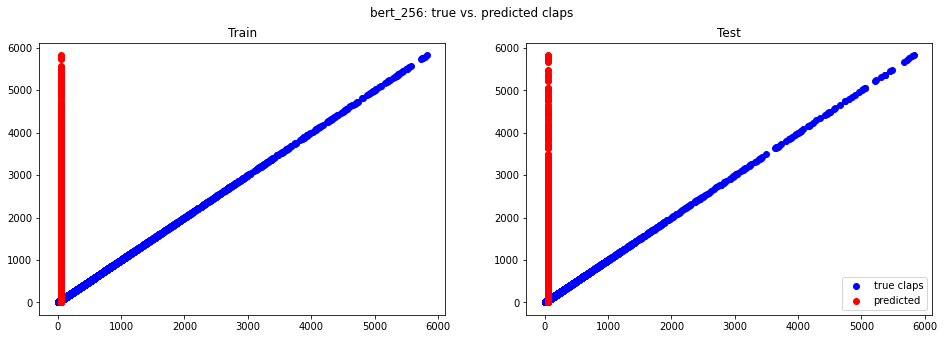

In [14]:
models.visualize('bert_256')

In [18]:
min(models.predictions['bert_256']['train'])

53.315384